# 1: Text Classification

## Using BERT

Detecting GPU

Please uncomment this code, if your system has GPU.

In [ ]:
# import tensorflow as tf

# device_name = tf.test.gpu_device_name()

# if device_name == '/device:GPU:0':
#     print('Found GPU at: {}'.format(device_name))
# else:
#     raise SystemError('GPU device not found')

In [27]:
import torch

if torch.cuda.is_available():    
    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [2]:
# from google.colab import drive
# drive.mount('/content/drive') 

In [229]:
# !pip3 install transformers==2.4.1
import transformers
import pandas as pd
import torch
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, matthews_corrcoef
import numpy as np
from matplotlib import pyplot

### Reading data

In [2]:
# Loading the dataset
df_train = pd.read_csv(".//assignment1_data/axcs_train.csv", delimiter=',')
df_test = pd.read_csv(".//assignment1_data/axcs_test.csv", delimiter=',')
df_train_1000 = df_train[:1000]

print('Number of training records: {:,}\n'.format(df_train.shape[0]))
print('Number of testing records: {:,}\n'.format(df_test.shape[0]))
print('Number of df_train_1000 records: {:,}\n'.format(df_train_1000.shape[0]))

Number of training records: 54,731

Number of testing records: 19,678

Number of df_train_1000 records: 1,000



In [3]:
df_train.sample(5)

,ID,URL,Date,Title,InfoTheory,CompVis,Math,Abstract
46286,no-14043816,arxiv.org/abs/1404.3816,2014-04-15,A Kalman filter powered by $\mathcal{H}^2$-mat...,0,0,1,A Kalman filter powered by matrices for quasi...
24468,no-12014500,arxiv.org/abs/1201.4500,2012-01-21,Requirements and the baseline plan,0,0,0,Requirements and the baseline plan For each s...
48598,no-14065299,arxiv.org/abs/1406.5299,2014-06-20,Properties and Complexity of Fan-Planarity,0,0,0,Properties and Complexity of Fan-Planarity In...
49565,no-14075889,arxiv.org/abs/1407.5889,2014-07-22,Domain-partitioned element management systems ...,0,0,0,Domain-partitioned element management systems...
13719,no-10035633,arxiv.org/abs/1003.5633,2010-03-29,Performance Analysis of Best suited Adaptive E...,0,0,0,Performance Analysis of Best suited Adaptive ...


In [4]:
df_train.head(5)[['Title','Abstract','InfoTheory','CompVis','Math']]

,Title,Abstract,InfoTheory,CompVis,Math
0,Nested satisfiability,Nested satisfiability A special case of the s...,0,0,0
1,A note on digitized angles,A note on digitized angles We study the confi...,0,0,0
2,Textbook examples of recursion,Textbook examples of recursion We discuss pro...,0,0,0
3,Theory and practice,Theory and practice The author argues to Sili...,0,0,0
4,Context-free multilanguages,Context-free multilanguages This article is a...,0,0,0


In [5]:
Abstracts = df_train.Abstract.values
InfoTheory_labels = df_train.InfoTheory.values
CompVis_labels = df_train.CompVis.values
Math_labels = df_train.Math.values

Abstracts_1000 = Abstracts[:1000]
InfoTheory_labels_1000 = InfoTheory_labels[:1000]
CompVis_labels_1000 = CompVis_labels[:1000]
Math_labels_1000 = Math_labels[:1000]

## BERT Tokenizer

In [6]:
from transformers import BertTokenizer

# Loading the BERT tokenizer.
print('Loading BERT tokenizer')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [7]:
tokenizer

## Using BERT with BERT tokenizer on all the InfoTheory Labels

In [8]:
# Printing the original sentence
print(' Original: ', Abstracts[0])

# Printing the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(Abstracts[0]))

# Printing the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(Abstracts[0])))

 Original:   Nested satisfiability A special case of the satisfiability problem, in which the clauses have a hierarchical structure, is shown to be solvable in linear time, assuming that the clauses have been represented in a convenient way. 
Tokenized:  ['nest', '##ed', 'sat', '##is', '##fia', '##bility', 'a', 'special', 'case', 'of', 'the', 'sat', '##is', '##fia', '##bility', 'problem', ',', 'in', 'which', 'the', 'clauses', 'have', 'a', 'hierarchical', 'structure', ',', 'is', 'shown', 'to', 'be', 'sol', '##vable', 'in', 'linear', 'time', ',', 'assuming', 'that', 'the', 'clauses', 'have', 'been', 'represented', 'in', 'a', 'convenient', 'way', '.']
Token IDs:  [9089, 2098, 2938, 2483, 22749, 8553, 1037, 2569, 2553, 1997, 1996, 2938, 2483, 22749, 8553, 3291, 1010, 1999, 2029, 1996, 24059, 2031, 1037, 25835, 3252, 1010, 2003, 3491, 2000, 2022, 14017, 12423, 1999, 7399, 2051, 1010, 10262, 2008, 1996, 24059, 2031, 2042, 3421, 1999, 1037, 14057, 2126, 1012]


### Sentences to IDs

In [11]:
# print('Max sentence length: ', max([len(tokenizer.tokenize(abs)) for abs in Abstracts]))

In [12]:
import time
start_time = time.time()
# Tokenizing all of the abstracts and map the tokenized words to thier word IDs.
input_ids = []

for abstract in Abstracts:
    encoded_abstract = tokenizer.encode(
                        abstract,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 745, #we got the max len 743 and after 2 special tokens
                   )
    
    # Adding the encoded sentence to the list
    input_ids.append(encoded_abstract)

print('Original: ', Abstracts[0])
print('Token IDs:', input_ids[0])
print("--- %s seconds ---" % (time.time() - start_time))

Original:   Nested satisfiability A special case of the satisfiability problem, in which the clauses have a hierarchical structure, is shown to be solvable in linear time, assuming that the clauses have been represented in a convenient way. 
Token IDs: [101, 9089, 2098, 2938, 2483, 22749, 8553, 1037, 2569, 2553, 1997, 1996, 2938, 2483, 22749, 8553, 3291, 1010, 1999, 2029, 1996, 24059, 2031, 1037, 25835, 3252, 1010, 2003, 3491, 2000, 2022, 14017, 12423, 1999, 7399, 2051, 1010, 10262, 2008, 1996, 24059, 2031, 2042, 3421, 1999, 1037, 14057, 2126, 1012, 102]
--- 192.44011521339417 seconds ---



### Padding & Truncating

In [ ]:
# print('Max sentence length: ', max([len(sen) for sen in input_ids]))

In [ ]:
# !pip3 install keras

In [13]:
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 16 #performing truncate

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))


input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')


Padding/truncating all sentences to 16 values...

Padding token: "[PAD]", ID: 0

Done.


### Attention Masks

In [14]:
#attention masks
attention_masks = []

for id in input_ids:
    
    # Creating the attention mask.
    # If a token ID is 0, setting the mask to 0.
    # If a token ID is > 0, setting the mask to 1.
    att_mask = [int(token_id > 0) for token_id in id]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

### Training & Validation Split


In [15]:
# Using train_test_split to split our data into train and validation sets for the training
from sklearn.model_selection import train_test_split

# Using 90% for training and 10% for validation for both training data and attention masks
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, InfoTheory_labels, 
                                                            random_state=2018, test_size=0.1)

train_masks, validation_masks, _, _ = train_test_split(attention_masks, InfoTheory_labels,
                                             random_state=2018, test_size=0.1)

In [16]:
# Converting all inputs and labels into torch tensors which is the required datatypefor our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [17]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler


#defining batch size
batch_size = 32

# DataLoader for the training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# DataLoader for the validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

### BertForSequenceClassification

In [9]:
#!pip3 install ipywidgets
#!pip3 install --upgrade jupyter_client
from ipywidgets import IntProgress

In [10]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Loading BertForSequenceClassification, the pretrained BERT model. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Using the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

In [11]:
# Getting all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))
print('==== Embedding Layer ====\n')
for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== First Transformer ====\n')
for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== Output Layer ====\n')
for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

### Optimizer & Learning Rate Scheduler

In [12]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8 
                )

In [29]:
from transformers import get_linear_schedule_with_warmup

epochs = 1

total_steps = len(train_dataloader) * epochs

#learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
scheduler

### Training Loop

In [14]:
import numpy as np

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [15]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [25]:
# model.cuda()

In [26]:
start_time = time.time()
import random

seed_val = 100

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the avg loss after each epoch.
loss_values = []

for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_loss = 0

    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        #Progress update every 5 batches.
        if step % 5 == 0 and not step == 0:
            #Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

       
        # batch contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
#         print("b_input_ids",len(b_input_ids),type(b_input_ids))
#         print(b_input_ids.shape)
#         print("b_input_mask",len(b_input_mask),type(b_input_mask))
#         print(b_input_mask.shape)
#         print("b_labels",len(b_labels),type(b_labels))
#         print(b_labels.shape)

        model.zero_grad()        

        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        loss = outputs[0]

        total_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)            
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()
 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    for batch in validation_dataloader:
        
        batch = tuple(t.to(device) for t in batch)
        
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients..
        with torch.no_grad():        

            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculating the accuracy for this batch
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        eval_accuracy += tmp_eval_accuracy

        nb_eval_steps += 1

    # Reporting the final accuracy for the validation.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")
print("--- %s seconds ---" % (time.time() - start_time))


======== Epoch 1 / 1 ========
Training...


/Users/chaitanyamuvva/opt/anaconda3/lib/python3.8/site-packages/transformers/optimization.py:155: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1005.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)


  Batch     5  of  1,540.    Elapsed: 0:00:55.
  Batch    10  of  1,540.    Elapsed: 0:01:23.
  Batch    15  of  1,540.    Elapsed: 0:01:46.
  Batch    20  of  1,540.    Elapsed: 0:02:14.
  Batch    25  of  1,540.    Elapsed: 0:02:37.
  Batch    30  of  1,540.    Elapsed: 0:02:59.
  Batch    35  of  1,540.    Elapsed: 0:03:28.
  Batch    40  of  1,540.    Elapsed: 0:04:48.
  Batch    45  of  1,540.    Elapsed: 0:05:13.
  Batch    50  of  1,540.    Elapsed: 0:05:41.
  Batch    55  of  1,540.    Elapsed: 0:06:09.
  Batch    60  of  1,540.    Elapsed: 0:06:34.
  Batch    65  of  1,540.    Elapsed: 0:07:00.
  Batch    70  of  1,540.    Elapsed: 0:07:35.
  Batch    75  of  1,540.    Elapsed: 0:08:44.
  Batch    80  of  1,540.    Elapsed: 0:09:08.
  Batch    85  of  1,540.    Elapsed: 0:09:35.
  Batch    90  of  1,540.    Elapsed: 0:10:07.
  Batch    95  of  1,540.    Elapsed: 0:10:32.
  Batch   100  of  1,540.    Elapsed: 0:11:11.
  Batch   105  of  1,540.    Elapsed: 1:38:07.
  Batch   110

In [27]:
loss_values

[0.22120463061206913]

In [199]:
# Create sentence and label lists for the test data
sentences = df_test.Abstract.values
labels = df_test.InfoTheory.values

input_ids = []

for sent in sentences:
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 745,
                   )
    
    input_ids.append(encoded_sent)

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")
attention_masks = []

for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

# Convert to tensors
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

# Setting the batch size  
batch_size = 32  

#DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [200]:
# Prediction on test data
print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

model.eval()

predictions , true_labels = [], []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch
  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)
  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  predictions.append(logits)
  true_labels.append(label_ids)

print('done.')

Predicting labels for 19,678 test sentences...
done.


In [201]:
print('Positive samples: %d of %d (%.2f%%)' % (df_test.InfoTheory.sum(), len(df_test.InfoTheory), (df_test.InfoTheory.sum() / len(df_test.InfoTheory) * 100.0)))

Positive samples: 3616 of 19678 (18.38%)


In [202]:
# Combining the predictions for every batch into a list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

accuracy = accuracy_score(flat_true_labels, flat_predictions)
print('Accuray: %.3f' % accuracy)

Accuray: 0.927


In [43]:
import os

output_dir = './model_save/BERT/InfoTheory/full/L16_B32'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to ./model_save/BERT/InfoTheory/full/L16_B32


('./model_save/BERT/InfoTheory/full/L16_B32/vocab.txt',
 './model_save/BERT/InfoTheory/full/L16_B32/special_tokens_map.json',
 './model_save/BERT/InfoTheory/full/L16_B32/added_tokens.json')

In [196]:
from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained("./model_save/BERT/InfoTheory/full/L16_B32")

[[15454   608]
 [  829  2787]]
Accuracy: 0.9269742860046752
Macro Precision: 0.8850005567033825
Macro Recall: 0.866443916025622
Macro F1 score:0.875304551452492


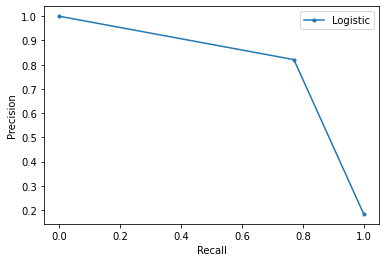

In [203]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, matthews_corrcoef
import numpy as np
from matplotlib import pyplot

y_predict = np.asarray(flat_predictions)
y_test = np.asarray(flat_true_labels)
print(confusion_matrix(y_test,y_predict))
recall=recall_score(y_test,y_predict,average='macro')
precision=precision_score(y_test,y_predict,average='macro')
f1score=f1_score(y_test,y_predict,average='macro')
accuracy=accuracy_score(y_test,y_predict)
print('Accuracy: '+ str(accuracy))
print('Macro Precision: '+ str(precision))
print('Macro Recall: '+ str(recall))
print('Macro F1 score:'+ str(f1score))

lr_precision, lr_recall, _ = precision_recall_curve(flat_true_labels,flat_predictions)
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## BERT L16_B32 on all the CompVis records using BERT tokenizer

In [115]:
import time
start_time = time.time()
# Tokenizing all of the abstracts and map the tokenized words to thier word IDs.
input_ids = []

for abstract in Abstracts:
    encoded_abstract = tokenizer.encode(
                        abstract,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 745, #we got the max len 743 and after 2 special tokens
                   )
    
    # Adding the encoded sentence to the list
    input_ids.append(encoded_abstract)

print('Original: ', Abstracts[0])
print('Token IDs:', input_ids[0])

from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 16 #performing truncate

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))


input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')


#attention masks
attention_masks = []

for id in input_ids:
    
    # Creating the attention mask.
    # If a token ID is 0, setting the mask to 0.
    # If a token ID is > 0, setting the mask to 1.
    att_mask = [int(token_id > 0) for token_id in id]
    
    attention_masks.append(att_mask)

print("--- %s seconds ---" % (time.time() - start_time))

Original:   Nested satisfiability A special case of the satisfiability problem, in which the clauses have a hierarchical structure, is shown to be solvable in linear time, assuming that the clauses have been represented in a convenient way. 
Token IDs: [101, 9089, 2098, 2938, 2483, 22749, 8553, 1037, 2569, 2553, 1997, 1996, 2938, 2483, 22749, 8553, 3291, 1010, 1999, 2029, 1996, 24059, 2031, 1037, 25835, 3252, 1010, 2003, 3491, 2000, 2022, 14017, 12423, 1999, 7399, 2051, 1010, 10262, 2008, 1996, 24059, 2031, 2042, 3421, 1999, 1037, 14057, 2126, 1012, 102]

Padding/truncating all sentences to 16 values...

Padding token: "[PAD]", ID: 0

Done.
--- 170.43667006492615 seconds ---


In [117]:
# Using train_test_split to split our data into train and validation sets for the training
from sklearn.model_selection import train_test_split

# Using 90% for training and 10% for validation for both training data and attention masks
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, CompVis_labels, 
                                                            random_state=2018, test_size=0.1)

train_masks, validation_masks, _, _ = train_test_split(attention_masks, CompVis_labels,
                                             random_state=2018, test_size=0.1)

# Converting all inputs and labels into torch tensors which is the required datatypefor our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)


from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#defining batch size
batch_size = 32

# DataLoader for the training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# DataLoader for the validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

#training

In [119]:
start_time = time.time()
import random

seed_val = 100

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the avg loss after each epoch.
loss_values = []

for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_loss = 0

    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        #Progress update every 5 batches.
        if step % 5 == 0 and not step == 0:
            #Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

       
        # batch contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
#         print("b_input_ids",len(b_input_ids),type(b_input_ids))
#         print(b_input_ids.shape)
#         print("b_input_mask",len(b_input_mask),type(b_input_mask))
#         print(b_input_mask.shape)
#         print("b_labels",len(b_labels),type(b_labels))
#         print(b_labels.shape)

        model.zero_grad()        

        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        loss = outputs[0]

        total_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)            
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()
 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    for batch in validation_dataloader:
        
        batch = tuple(t.to(device) for t in batch)
        
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients..
        with torch.no_grad():        

            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculating the accuracy for this batch
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        eval_accuracy += tmp_eval_accuracy

        nb_eval_steps += 1

    # Reporting the final accuracy for the validation.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")
print("--- %s seconds ---" % (time.time() - start_time))


======== Epoch 1 / 1 ========
Training...
  Batch     5  of  1,540.    Elapsed: 0:00:24.
  Batch    10  of  1,540.    Elapsed: 0:00:42.
  Batch    15  of  1,540.    Elapsed: 0:01:01.
  Batch    20  of  1,540.    Elapsed: 0:01:21.
  Batch    25  of  1,540.    Elapsed: 0:01:43.
  Batch    30  of  1,540.    Elapsed: 0:02:06.
  Batch    35  of  1,540.    Elapsed: 0:02:28.
  Batch    40  of  1,540.    Elapsed: 0:03:00.
  Batch    45  of  1,540.    Elapsed: 0:03:21.
  Batch    50  of  1,540.    Elapsed: 0:03:45.
  Batch    55  of  1,540.    Elapsed: 0:04:07.
  Batch    60  of  1,540.    Elapsed: 0:04:28.
  Batch    65  of  1,540.    Elapsed: 0:04:51.
  Batch    70  of  1,540.    Elapsed: 0:05:14.
  Batch    75  of  1,540.    Elapsed: 0:05:39.
  Batch    80  of  1,540.    Elapsed: 0:06:01.
  Batch    85  of  1,540.    Elapsed: 0:06:21.
  Batch    90  of  1,540.    Elapsed: 0:06:40.
  Batch    95  of  1,540.    Elapsed: 0:07:00.
  Batch   100  of  1,540.    Elapsed: 0:07:22.
  Batch   105  of

In [189]:
#Preparing testing data
sentences = df_test.Abstract.values
labels = df_test.CompVis.values

input_ids_test = []

for sent in sentences:
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 745,
                   )
    
    input_ids_test.append(encoded_sent)

input_ids_test = pad_sequences(input_ids_test, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

attention_masks_test = []

for seq in input_ids_test:
  seq_mask = [float(i>0) for i in seq]
  attention_masks_test.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids_test)
prediction_masks = torch.tensor(attention_masks_test)
prediction_labels = torch.tensor(labels)

batch_size = 32  

prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [190]:
# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

model.eval()

predictions , true_labels = [], []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)

  b_input_ids, b_input_mask, b_labels = batch
  

  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  predictions.append(logits)
  true_labels.append(label_ids)

print('done.')

Predicting labels for 19,678 test sentences...
done.


In [191]:
print('Positive samples: %d of %d (%.2f%%)' % (df_test.CompVis.sum(), len(df_test.CompVis), (df_test.CompVis.sum() / len(df_test.CompVis) * 100.0)))

Positive samples: 2152 of 19678 (10.94%)


In [192]:
# Combining the predictions for every batch into a list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a list.
flat_true_labels = [item for sublist in true_labels for item in sublist]


accuracy = accuracy_score(flat_true_labels, flat_predictions)
print('Accuray: %.3f' % accuracy)

Accuray: 0.891


In [127]:
import os

output_dir = './model_save/BERT/CompVis/full/L16_B32'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to ./model_save/BERT/CompVis/full/L16_B32


('./model_save/BERT/CompVis/full/L16_B32/vocab.txt',
 './model_save/BERT/CompVis/full/L16_B32/special_tokens_map.json',
 './model_save/BERT/CompVis/full/L16_B32/added_tokens.json')

In [188]:
# from transformers import BertForSequenceClassification

# model = BertForSequenceClassification.from_pretrained("./model_save/BERT/CompVis/full/L16_B32")

[[17526     0]
 [ 2152     0]]
Accuracy: 0.8906392926110377
Macro Precision: 0.44531964630551885
Macro Recall: 0.5
Macro F1 score:0.4710783786689603


/Users/chaitanyamuvva/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


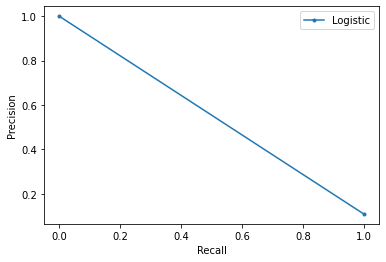

In [195]:
# from transformers import BertForSequenceClassification

# model = BertForSequenceClassification.from_pretrained("./model_save/BERT/CompVis/full/L16_B32")
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, matthews_corrcoef
import numpy as np
from matplotlib import pyplot

y_predict = np.asarray(flat_predictions)
y_test = np.asarray(flat_true_labels)
print(confusion_matrix(y_test,y_predict))
recall=recall_score(y_test,y_predict,average='macro')
precision=precision_score(y_test,y_predict,average='macro')
f1score=f1_score(y_test,y_predict,average='macro')
accuracy=accuracy_score(y_test,y_predict)
print('Accuracy: '+ str(accuracy))
print('Macro Precision: '+ str(precision))
print('Macro Recall: '+ str(recall))
print('Macro F1 score:'+ str(f1score))

lr_precision, lr_recall, _ = precision_recall_curve(flat_true_labels,flat_predictions)
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

### BERT L16_B32 on all the Math records using BERT Tokenizer

In [128]:
import time
start_time = time.time()
# Tokenizing all of the abstracts and map the tokenized words to thier word IDs.
input_ids = []

for abstract in Abstracts:
    encoded_abstract = tokenizer.encode(
                        abstract,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 745, #we got the max len 743 and after 2 special tokens
                   )
    
    # Adding the encoded sentence to the list
    input_ids.append(encoded_abstract)

print('Original: ', Abstracts[0])
print('Token IDs:', input_ids[0])

from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 16 #performing truncate

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))


input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')


#attention masks
attention_masks = []

for id in input_ids:
    
    # Creating the attention mask.
    # If a token ID is 0, setting the mask to 0.
    # If a token ID is > 0, setting the mask to 1.
    att_mask = [int(token_id > 0) for token_id in id]
    
    attention_masks.append(att_mask)

print("--- %s seconds ---" % (time.time() - start_time))

Original:   Nested satisfiability A special case of the satisfiability problem, in which the clauses have a hierarchical structure, is shown to be solvable in linear time, assuming that the clauses have been represented in a convenient way. 
Token IDs: [101, 9089, 2098, 2938, 2483, 22749, 8553, 1037, 2569, 2553, 1997, 1996, 2938, 2483, 22749, 8553, 3291, 1010, 1999, 2029, 1996, 24059, 2031, 1037, 25835, 3252, 1010, 2003, 3491, 2000, 2022, 14017, 12423, 1999, 7399, 2051, 1010, 10262, 2008, 1996, 24059, 2031, 2042, 3421, 1999, 1037, 14057, 2126, 1012, 102]

Padding/truncating all sentences to 16 values...

Padding token: "[PAD]", ID: 0

Done.
--- 184.9595546722412 seconds ---


In [129]:
# Using train_test_split to split our data into train and validation sets for the training
from sklearn.model_selection import train_test_split

# Using 90% for training and 10% for validation for both training data and attention masks
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, Math_labels, 
                                                            random_state=2018, test_size=0.1)

train_masks, validation_masks, _, _ = train_test_split(attention_masks, Math_labels,
                                             random_state=2018, test_size=0.1)

# Converting all inputs and labels into torch tensors which is the required datatypefor our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)


from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#defining batch size
batch_size = 32

# DataLoader for the training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# DataLoader for the validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [130]:
start_time = time.time()
import random

seed_val = 100

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the avg loss after each epoch.
loss_values = []

for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_loss = 0

    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        #Progress update every 5 batches.
        if step % 5 == 0 and not step == 0:
            #Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

       
        # batch contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
#         print("b_input_ids",len(b_input_ids),type(b_input_ids))
#         print(b_input_ids.shape)
#         print("b_input_mask",len(b_input_mask),type(b_input_mask))
#         print(b_input_mask.shape)
#         print("b_labels",len(b_labels),type(b_labels))
#         print(b_labels.shape)

        model.zero_grad()        

        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        loss = outputs[0]

        total_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)            
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()
 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    for batch in validation_dataloader:
        
        batch = tuple(t.to(device) for t in batch)
        
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients..
        with torch.no_grad():        

            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculating the accuracy for this batch
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        eval_accuracy += tmp_eval_accuracy

        nb_eval_steps += 1

    # Reporting the final accuracy for the validation.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")
print("--- %s seconds ---" % (time.time() - start_time))


======== Epoch 1 / 1 ========
Training...
  Batch     5  of  1,540.    Elapsed: 0:00:27.
  Batch    10  of  1,540.    Elapsed: 0:00:48.
  Batch    15  of  1,540.    Elapsed: 0:01:08.
  Batch    20  of  1,540.    Elapsed: 0:01:27.
  Batch    25  of  1,540.    Elapsed: 0:01:46.
  Batch    30  of  1,540.    Elapsed: 0:02:05.
  Batch    35  of  1,540.    Elapsed: 0:02:25.
  Batch    40  of  1,540.    Elapsed: 0:02:47.
  Batch    45  of  1,540.    Elapsed: 0:03:10.
  Batch    50  of  1,540.    Elapsed: 0:03:31.
  Batch    55  of  1,540.    Elapsed: 0:03:53.
  Batch    60  of  1,540.    Elapsed: 0:04:14.
  Batch    65  of  1,540.    Elapsed: 0:04:37.
  Batch    70  of  1,540.    Elapsed: 0:05:00.
  Batch    75  of  1,540.    Elapsed: 0:05:21.
  Batch    80  of  1,540.    Elapsed: 0:05:44.
  Batch    85  of  1,540.    Elapsed: 0:06:06.
  Batch    90  of  1,540.    Elapsed: 0:06:27.
  Batch    95  of  1,540.    Elapsed: 0:06:47.
  Batch   100  of  1,540.    Elapsed: 0:07:07.
  Batch   105  of

In [205]:
#Preparing testing data
sentences = df_test.Abstract.values
labels = df_test.Math.values

input_ids_test = []

for sent in sentences:
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 745,
                   )

    input_ids_test.append(encoded_sent)

input_ids_test = pad_sequences(input_ids_test, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

attention_masks_test = []

for seq in input_ids_test:
  seq_mask = [float(i>0) for i in seq]
  attention_masks_test.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids_test)
prediction_masks = torch.tensor(attention_masks_test)
prediction_labels = torch.tensor(labels)

batch_size = 32  

prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [206]:
# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

model.eval()

predictions , true_labels = [], []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)

  b_input_ids, b_input_mask, b_labels = batch
  

  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  predictions.append(logits)
  true_labels.append(label_ids)

print('done.')

Predicting labels for 19,678 test sentences...
done.


In [207]:
print('Positive samples: %d of %d (%.2f%%)' % (df_test.Math.sum(), len(df_test.Math), (df_test.Math.sum() / len(df_test.Math) * 100.0)))

Positive samples: 5930 of 19678 (30.14%)


In [208]:
# Combining the predictions for every batch into a list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a list.
flat_true_labels = [item for sublist in true_labels for item in sublist]


accuracy = accuracy_score(flat_true_labels, flat_predictions)
print('Accuray: %.3f' % accuracy)

Accuray: 0.699


In [135]:
import os

output_dir = './model_save/BERT/Math/full/L16_B32'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to ./model_save/BERT/Math/full/L16_B32


('./model_save/BERT/Math/full/L16_B32/vocab.txt',
 './model_save/BERT/Math/full/L16_B32/special_tokens_map.json',
 './model_save/BERT/Math/full/L16_B32/added_tokens.json')

In [210]:
# from transformers import BertForSequenceClassification
# model = BertForSequenceClassification.from_pretrained("./model_save/BERT/Math/full/L16_B32")

[[13748     0]
 [ 5930     0]]
Accuracy: 0.6986482366094116
Macro Precision: 0.3493241183047058
Macro Recall: 0.5
Macro F1 score:0.4112965954646084


/Users/chaitanyamuvva/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


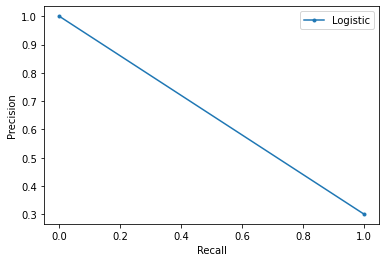

In [209]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, matthews_corrcoef
import numpy as np
from matplotlib import pyplot

y_predict = np.asarray(flat_predictions)
y_test = np.asarray(flat_true_labels)
print(confusion_matrix(y_test,y_predict))
recall=recall_score(y_test,y_predict,average='macro')
precision=precision_score(y_test,y_predict,average='macro')
f1score=f1_score(y_test,y_predict,average='macro')
accuracy=accuracy_score(y_test,y_predict)
print('Accuracy: '+ str(accuracy))
print('Macro Precision: '+ str(precision))
print('Macro Recall: '+ str(recall))
print('Macro F1 score:'+ str(f1score))

lr_precision, lr_recall, _ = precision_recall_curve(flat_true_labels,flat_predictions)
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

### BERT L16-B32 with InfoTheory first 1000 records using BERT tokenizer

In [58]:
len(Abstracts_1000)

1000

In [78]:
import time
start_time = time.time()
# Tokenizing all of the abstracts and map the tokenized words to thier word IDs.
input_ids = []

for abstract in Abstracts_1000:
    encoded_abstract = tokenizer.encode(
                        abstract,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 745, #we got the max len 743 and after 2 special tokens
                   )
    input_ids.append(encoded_abstract)

print('Original: ', Abstracts_1000[0])
print('Token IDs:', input_ids[0])
print("--- %s seconds ---" % (time.time() - start_time))

Original:   Nested satisfiability A special case of the satisfiability problem, in which the clauses have a hierarchical structure, is shown to be solvable in linear time, assuming that the clauses have been represented in a convenient way. 
Token IDs: [101, 9089, 2098, 2938, 2483, 22749, 8553, 1037, 2569, 2553, 1997, 1996, 2938, 2483, 22749, 8553, 3291, 1010, 1999, 2029, 1996, 24059, 2031, 1037, 25835, 3252, 1010, 2003, 3491, 2000, 2022, 14017, 12423, 1999, 7399, 2051, 1010, 10262, 2008, 1996, 24059, 2031, 2042, 3421, 1999, 1037, 14057, 2126, 1012, 102]
--- 4.0122129917144775 seconds ---


In [60]:
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 16

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')


Padding/truncating all sentences to 16 values...

Padding token: "[PAD]", ID: 0

Done.


In [61]:
# Creating attention masks
attention_masks = []

for id in input_ids:
    
    # Creating the attention mask.
    #   - If a token ID is 0, set the mask to 0.
    #   - If a token ID is > 0, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in id]
    
    attention_masks.append(att_mask)

In [62]:

from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, InfoTheory_labels_1000, 
                                                            random_state=2018, test_size=0.1)
#Doing the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, InfoTheory_labels_1000,
                                             random_state=2018, test_size=0.1)

In [63]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [64]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#defining batch size
batch_size = 32

#DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

#DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [65]:
start_time = time.time()
import random

seed_val = 100

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the avg loss after each epoch.
loss_values = []

for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_loss = 0

    model.train()

    # For each batch of training data
    for step, batch in enumerate(train_dataloader):

        #Progress update every 5 batches.
        if step % 5 == 0 and not step == 0:
            #Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

       
        # batch contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
#         print("b_input_ids",len(b_input_ids),type(b_input_ids))
#         print(b_input_ids.shape)
#         print("b_input_mask",len(b_input_mask),type(b_input_mask))
#         print(b_input_mask.shape)
#         print("b_labels",len(b_labels),type(b_labels))
#         print(b_labels.shape)

        model.zero_grad()        

        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        loss = outputs[0]

        total_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)            
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()
 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    for batch in validation_dataloader:
        
        batch = tuple(t.to(device) for t in batch)
        
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients..
        with torch.no_grad():        

            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculating the accuracy for this batch
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        eval_accuracy += tmp_eval_accuracy

        nb_eval_steps += 1

    # Reporting the final accuracy for the validation.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")
print("--- %s seconds ---" % (time.time() - start_time))


======== Epoch 1 / 1 ========
Training...
  Batch     5  of     29.    Elapsed: 0:00:22.
  Batch    10  of     29.    Elapsed: 0:00:40.
  Batch    15  of     29.    Elapsed: 0:00:58.
  Batch    20  of     29.    Elapsed: 0:01:20.
  Batch    25  of     29.    Elapsed: 0:01:43.

  Average training loss: 0.04
  Training epcoh took: 0:01:54

Running Validation...
  Accuracy: 1.00
  Validation took: 0:00:03

Training complete!
--- 117.72019028663635 seconds ---


In [212]:
#Preparing testing data
sentences = df_test.Abstract.values
labels = df_test.InfoTheory.values

input_ids_test = []

for sent in sentences:
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 745,
                   )
    
    input_ids_test.append(encoded_sent)

input_ids_test = pad_sequences(input_ids_test, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

attention_masks_test = []

for seq in input_ids_test:
  seq_mask = [float(i>0) for i in seq]
  attention_masks_test.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids_test)
prediction_masks = torch.tensor(attention_masks_test)
prediction_labels = torch.tensor(labels)

batch_size = 32  

prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [213]:
# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

model.eval()

predictions , true_labels = [], []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)

  b_input_ids, b_input_mask, b_labels = batch
  

  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  predictions.append(logits)
  true_labels.append(label_ids)

print('done.')

Predicting labels for 19,678 test sentences...
done.


In [214]:
print('Positive samples: %d of %d (%.2f%%)' % (df_test.InfoTheory.sum(), len(df_test.InfoTheory), (df_test.InfoTheory.sum() / len(df_test.InfoTheory) * 100.0)))

Positive samples: 3616 of 19678 (18.38%)


In [215]:
# Combine the predictions for each batch into a list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

accuracy = accuracy_score(flat_true_labels, flat_predictions)
print('Accuray: %.3f' % accuracy)

Accuray: 0.816


[[16062     0]
 [ 3616     0]]
Accuracy: 0.8162414879560931
Macro Precision: 0.40812074397804654
Macro Recall: 0.5
Macro F1 score:0.44941242305540013


/Users/chaitanyamuvva/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


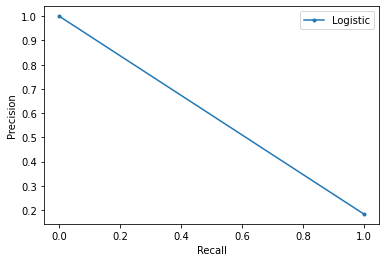

In [216]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, matthews_corrcoef
import numpy as np
from matplotlib import pyplot

y_predict = np.asarray(flat_predictions)
y_test = np.asarray(flat_true_labels)
print(confusion_matrix(y_test,y_predict))
recall=recall_score(y_test,y_predict,average='macro')
precision=precision_score(y_test,y_predict,average='macro')
f1score=f1_score(y_test,y_predict,average='macro')
accuracy=accuracy_score(y_test,y_predict)
print('Accuracy: '+ str(accuracy))
print('Macro Precision: '+ str(precision))
print('Macro Recall: '+ str(recall))
print('Macro F1 score:'+ str(f1score))

lr_precision, lr_recall, _ = precision_recall_curve(flat_true_labels,flat_predictions)
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Uncomment to save the model

In [72]:
import os

output_dir = './model_save/BERT/InfoTheory/1000/L16_B32'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

In [211]:
# from transformers import BertForSequenceClassification
# model = BertForSequenceClassification.from_pretrained('./model_save/BERT/InfoTheory/1000/L16_B32')

In [55]:
# model

### CompVis1000 training with BERT_L16_B32

In [92]:
import time
start_time = time.time()
# Tokenizing all of the abstracts and map the tokenized words to thier word IDs.
input_ids = []

for abstract in Abstracts_1000:
    encoded_abstract = tokenizer.encode(
                        abstract,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 745, #we got the max len 743 and after 2 special tokens
                   )
    input_ids.append(encoded_abstract)

print('Original: ', Abstracts_1000[0])
print('Token IDs:', input_ids[0])


from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 16

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')

# Creating attention masks
attention_masks = []

for id in input_ids:
    
    # Creating the attention mask.
    #   - If a token ID is 0, set the mask to 0.
    #   - If a token ID is > 0, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in id]
    
    attention_masks.append(att_mask)
    
print("--- %s seconds ---" % (time.time() - start_time))

Original:   Nested satisfiability A special case of the satisfiability problem, in which the clauses have a hierarchical structure, is shown to be solvable in linear time, assuming that the clauses have been represented in a convenient way. 
Token IDs: [101, 9089, 2098, 2938, 2483, 22749, 8553, 1037, 2569, 2553, 1997, 1996, 2938, 2483, 22749, 8553, 3291, 1010, 1999, 2029, 1996, 24059, 2031, 1037, 25835, 3252, 1010, 2003, 3491, 2000, 2022, 14017, 12423, 1999, 7399, 2051, 1010, 10262, 2008, 1996, 24059, 2031, 2042, 3421, 1999, 1037, 14057, 2126, 1012, 102]

Padding/truncating all sentences to 16 values...

Padding token: "[PAD]", ID: 0

Done.
--- 2.603178024291992 seconds ---


In [95]:
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, CompVis_labels_1000, 
                                                            random_state=2018, test_size=0.1)
#Doing the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, CompVis_labels_1000,
                                             random_state=2018, test_size=0.1)

In [96]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [97]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#defining batch size
batch_size = 32

#DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

#DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [98]:
start_time = time.time()
import random

seed_val = 100

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the avg loss after each epoch.
loss_values = []

for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_loss = 0

    model.train()

    # For each batch of training data
    for step, batch in enumerate(train_dataloader):

        #Progress update every 5 batches.
        if step % 5 == 0 and not step == 0:
            #Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

       
        # batch contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
#         print("b_input_ids",len(b_input_ids),type(b_input_ids))
#         print(b_input_ids.shape)
#         print("b_input_mask",len(b_input_mask),type(b_input_mask))
#         print(b_input_mask.shape)
#         print("b_labels",len(b_labels),type(b_labels))
#         print(b_labels.shape)

        model.zero_grad()        

        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        loss = outputs[0]

        total_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)            
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()
 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    for batch in validation_dataloader:
        
        batch = tuple(t.to(device) for t in batch)
        
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients..
        with torch.no_grad():        

            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculating the accuracy for this batch
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        eval_accuracy += tmp_eval_accuracy

        nb_eval_steps += 1

    # Reporting the final accuracy for the validation.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")
print("--- %s seconds ---" % (time.time() - start_time))


======== Epoch 1 / 1 ========
Training...
  Batch     5  of     29.    Elapsed: 0:00:23.
  Batch    10  of     29.    Elapsed: 0:00:41.
  Batch    15  of     29.    Elapsed: 0:01:01.
  Batch    20  of     29.    Elapsed: 0:01:24.
  Batch    25  of     29.    Elapsed: 0:01:47.

  Average training loss: 0.04
  Training epcoh took: 0:02:03

Running Validation...
  Accuracy: 1.00
  Validation took: 0:00:05

Training complete!
--- 127.69305300712585 seconds ---


Model testing with test data

In [218]:
labels = df_test.CompVis.values

prediction_inputs = torch.tensor(input_ids_test)
prediction_masks = torch.tensor(attention_masks_test)
prediction_labels = torch.tensor(labels)

batch_size = 32  

prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [219]:
# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

model.eval()

predictions , true_labels = [], []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)

  b_input_ids, b_input_mask, b_labels = batch
  

  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  predictions.append(logits)
  true_labels.append(label_ids)

print('done.')

Predicting labels for 19,678 test sentences...
done.


In [220]:
# Combine the predictions for each batch into a list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

accuracy = accuracy_score(flat_true_labels, flat_predictions)
print('Accuray: %.3f' % accuracy)

Accuray: 0.891


[[17526     0]
 [ 2152     0]]
Accuracy: 0.8906392926110377
Macro Precision: 0.44531964630551885
Macro Recall: 0.5
Macro F1 score:0.4710783786689603


/Users/chaitanyamuvva/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


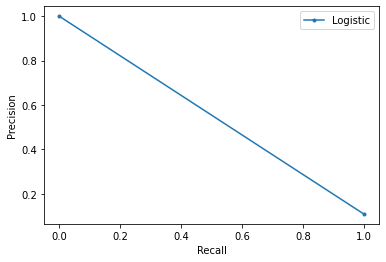

In [221]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, matthews_corrcoef
import numpy as np
from matplotlib import pyplot

y_predict = np.asarray(flat_predictions)
y_test = np.asarray(flat_true_labels)
print(confusion_matrix(y_test,y_predict))
recall=recall_score(y_test,y_predict,average='macro')
precision=precision_score(y_test,y_predict,average='macro')
f1score=f1_score(y_test,y_predict,average='macro')
accuracy=accuracy_score(y_test,y_predict)
print('Accuracy: '+ str(accuracy))
print('Macro Precision: '+ str(precision))
print('Macro Recall: '+ str(recall))
print('Macro F1 score:'+ str(f1score))

lr_precision, lr_recall, _ = precision_recall_curve(flat_true_labels,flat_predictions)
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Uncomment to save the model

In [102]:
import os

output_dir = './model_save/BERT/CompVis/1000/L16_B32'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to ./model_save/BERT/CompVis/1000/L16_B32


('./model_save/BERT/CompVis/1000/L16_B32/vocab.txt',
 './model_save/BERT/CompVis/1000/L16_B32/special_tokens_map.json',
 './model_save/BERT/CompVis/1000/L16_B32/added_tokens.json')

In [217]:
# from transformers import BertForSequenceClassification
# model = BertForSequenceClassification.from_pretrained('./model_save/BERT/CompVis/1000/L16_B32')

### Math1000 training with BERT_L16_B32

In [105]:
import time
start_time = time.time()
# Tokenizing all of the abstracts and map the tokenized words to thier word IDs.
input_ids = []

for abstract in Abstracts_1000:
    encoded_abstract = tokenizer.encode(
                        abstract,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 745, #we got the max len 743 and after 2 special tokens
                   )
    input_ids.append(encoded_abstract)

print('Original: ', Abstracts_1000[0])
print('Token IDs:', input_ids[0])


from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 16

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')

# Creating attention masks
attention_masks = []

for id in input_ids:
    
    # Creating the attention mask.
    #   - If a token ID is 0, set the mask to 0.
    #   - If a token ID is > 0, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in id]
    
    attention_masks.append(att_mask)
    
print("--- %s seconds ---" % (time.time() - start_time))

Original:   Nested satisfiability A special case of the satisfiability problem, in which the clauses have a hierarchical structure, is shown to be solvable in linear time, assuming that the clauses have been represented in a convenient way. 
Token IDs: [101, 9089, 2098, 2938, 2483, 22749, 8553, 1037, 2569, 2553, 1997, 1996, 2938, 2483, 22749, 8553, 3291, 1010, 1999, 2029, 1996, 24059, 2031, 1037, 25835, 3252, 1010, 2003, 3491, 2000, 2022, 14017, 12423, 1999, 7399, 2051, 1010, 10262, 2008, 1996, 24059, 2031, 2042, 3421, 1999, 1037, 14057, 2126, 1012, 102]

Padding/truncating all sentences to 16 values...

Padding token: "[PAD]", ID: 0

Done.
--- 2.7331020832061768 seconds ---


In [106]:
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, Math_labels_1000, 
                                                            random_state=2018, test_size=0.1)
#Doing the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, Math_labels_1000,
                                             random_state=2018, test_size=0.1)

In [107]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [108]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#defining batch size
batch_size = 32

#DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

#DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [109]:
start_time = time.time()
import random

seed_val = 100

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the avg loss after each epoch.
loss_values = []

for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_loss = 0

    model.train()

    # For each batch of training data
    for step, batch in enumerate(train_dataloader):

        #Progress update every 5 batches.
        if step % 5 == 0 and not step == 0:
            #Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

       
        # batch contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
#         print("b_input_ids",len(b_input_ids),type(b_input_ids))
#         print(b_input_ids.shape)
#         print("b_input_mask",len(b_input_mask),type(b_input_mask))
#         print(b_input_mask.shape)
#         print("b_labels",len(b_labels),type(b_labels))
#         print(b_labels.shape)

        model.zero_grad()        

        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        loss = outputs[0]

        total_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)            
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()
 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    for batch in validation_dataloader:
        
        batch = tuple(t.to(device) for t in batch)
        
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients..
        with torch.no_grad():        

            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculating the accuracy for this batch
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        eval_accuracy += tmp_eval_accuracy

        nb_eval_steps += 1

    # Reporting the final accuracy for the validation.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")
print("--- %s seconds ---" % (time.time() - start_time))


======== Epoch 1 / 1 ========
Training...
  Batch     5  of     29.    Elapsed: 0:00:21.
  Batch    10  of     29.    Elapsed: 0:00:41.
  Batch    15  of     29.    Elapsed: 0:01:03.
  Batch    20  of     29.    Elapsed: 0:01:31.
  Batch    25  of     29.    Elapsed: 0:01:52.

  Average training loss: 0.11
  Training epcoh took: 0:02:05

Running Validation...
  Accuracy: 0.98
  Validation took: 0:00:04

Training complete!
--- 129.10327768325806 seconds ---


Working with test data

In [223]:
labels = df_test.Math.values

prediction_inputs = torch.tensor(input_ids_test)
prediction_masks = torch.tensor(attention_masks_test)
prediction_labels = torch.tensor(labels)

batch_size = 32  

prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [224]:
# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

model.eval()

predictions , true_labels = [], []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)

  b_input_ids, b_input_mask, b_labels = batch
  

  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  predictions.append(logits)
  true_labels.append(label_ids)

print('done.')

Predicting labels for 19,678 test sentences...
done.


In [225]:
# Combine the predictions for each batch into a list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

accuracy = accuracy_score(flat_true_labels, flat_predictions)
print('Accuray: %.3f' % accuracy)

Accuray: 0.699


[[13748     0]
 [ 5930     0]]
Accuracy: 0.6986482366094116
Macro Precision: 0.3493241183047058
Macro Recall: 0.5
Macro F1 score:0.4112965954646084


/Users/chaitanyamuvva/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


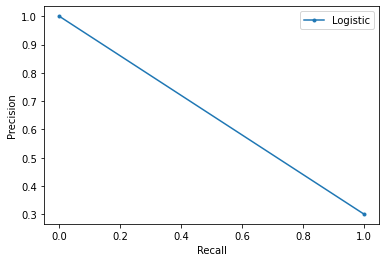

In [226]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, matthews_corrcoef
import numpy as np
from matplotlib import pyplot

y_predict = np.asarray(flat_predictions)
y_test = np.asarray(flat_true_labels)
print(confusion_matrix(y_test,y_predict))
recall=recall_score(y_test,y_predict,average='macro')
precision=precision_score(y_test,y_predict,average='macro')
f1score=f1_score(y_test,y_predict,average='macro')
accuracy=accuracy_score(y_test,y_predict)
print('Accuracy: '+ str(accuracy))
print('Macro Precision: '+ str(precision))
print('Macro Recall: '+ str(recall))
print('Macro F1 score:'+ str(f1score))

lr_precision, lr_recall, _ = precision_recall_curve(flat_true_labels,flat_predictions)
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [113]:
import os

output_dir = './model_save/BERT/Math/1000/L16_B32'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to ./model_save/BERT/Math/1000/L16_B32


('./model_save/BERT/Math/1000/L16_B32/vocab.txt',
 './model_save/BERT/Math/1000/L16_B32/special_tokens_map.json',
 './model_save/BERT/Math/1000/L16_B32/added_tokens.json')

In [227]:
# from transformers import BertForSequenceClassification
# model = BertForSequenceClassification.from_pretrained('./model_save/BERT/Math/1000/L16_B32')

## Using Lemmatokenizer using BERT

In [254]:
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from nltk import word_tokenize 

In [401]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl=WordNetLemmatizer()
    def __call__(self,doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

In [402]:
vectorizer=TfidfVectorizer(analyzer='word',input='content',
                           lowercase=True,
                           token_pattern='(?u)\\b\\w\\w+\\b',
                           min_df=3,
                           ngram_range=(1,2),
                           tokenizer=LemmaTokenizer())

In [403]:
trainDocs = df_train.Abstract.tolist()[:1000]
InfoTheoryLabels = df_train.InfoTheory.tolist() [:1000]
CompVisLabels = df_train.CompVis.tolist()[:1000]
MathLabels = df_train.Math.tolist()[:1000]

In [404]:
testDocs = df_test.Abstract.tolist()
InfoTheory_testLabels = df_test.InfoTheory.tolist()
CompVis_testLabels = df_test.CompVis.tolist()
Math_testLabels = df_test.Math.tolist()

In [405]:
x_train=vectorizer.fit_transform(trainDocs)
x_test=vectorizer.transform(testDocs)

In [406]:
x_train = x_train.todense().tolist()
x_test = x_test.todense().tolist()

In [407]:
# len(x_test[0])

In [408]:
# len(x_train)

In [409]:
# len(input_ids)

Adding encoded values of [CLS] and [SEP] as 101 and 102 in the first and last place respectively..

In [410]:
for i in x_train:
    i.insert(0,101)
    i.insert(10367,102)

In [411]:
len(x_train)

1000

In [412]:
for i in x_test:
    i.insert(0,101)
    i.insert(10367,102)

In [413]:
len(x_test)

19678

In [414]:
# len(x_test[0])

In [415]:
input_ids = x_train
input_ids_test = x_test

In [416]:
len(input_ids)

1000

## For 1000 InfoTheory labels using BERT model and LemmaTokenizer

In [417]:
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 16

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')

# Creating attention masks
attention_masks = []

for id in input_ids:
    
    # Creating the attention mask.
    #   - If a token ID is 0, set the mask to 0.
    #   - If a token ID is > 0, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in id]
    
    attention_masks.append(att_mask)


Padding/truncating all sentences to 16 values...

Done.


In [418]:
len(input_ids)

1000

In [419]:
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, InfoTheoryLabels, 
                                                            random_state=2018, test_size=0.1)
#Doing the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, InfoTheoryLabels,
                                             random_state=2018, test_size=0.1)
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#defining batch size
batch_size = 32

#DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

#DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [420]:
start_time = time.time()
import random

seed_val = 100

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the avg loss after each epoch.
loss_values = []

for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_loss = 0

    model.train()

    # For each batch of training data
    for step, batch in enumerate(train_dataloader):

        #Progress update every 5 batches.
        if step % 5 == 0 and not step == 0:
            #Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

       
        # batch contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
#         print("b_input_ids",len(b_input_ids),type(b_input_ids))
#         print(b_input_ids.shape)
#         print("b_input_mask",len(b_input_mask),type(b_input_mask))
#         print(b_input_mask.shape)
#         print("b_labels",len(b_labels),type(b_labels))
#         print(b_labels.shape)

        model.zero_grad()        

        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        loss = outputs[0]

        total_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)            
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()
 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    for batch in validation_dataloader:
        
        batch = tuple(t.to(device) for t in batch)
        
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients..
        with torch.no_grad():        

            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculating the accuracy for this batch
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        eval_accuracy += tmp_eval_accuracy

        nb_eval_steps += 1

    # Reporting the final accuracy for the validation.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")
print("--- %s seconds ---" % (time.time() - start_time))


======== Epoch 1 / 1 ========
Training...
  Batch     5  of     29.    Elapsed: 0:00:32.
  Batch    10  of     29.    Elapsed: 0:00:55.
  Batch    15  of     29.    Elapsed: 0:01:16.
  Batch    20  of     29.    Elapsed: 0:01:37.
  Batch    25  of     29.    Elapsed: 0:02:04.

  Average training loss: 0.20
  Training epcoh took: 0:02:17

Running Validation...
  Accuracy: 1.00
  Validation took: 0:00:04

Training complete!
--- 141.072340965271 seconds ---


In [421]:
# from keras.preprocessing.sequence import pad_sequences

# MAX_LEN = 16

# print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

# input_ids = pad_sequences(input_ids_test, maxlen=MAX_LEN, dtype="long", 
#                           value=0, truncating="post", padding="post")

# print('\nDone.')

# # Creating attention masks
# attention_masks = []

# for id in input_ids_test:
    
#     # Creating the attention mask.
#     #   - If a token ID is 0, set the mask to 0.
#     #   - If a token ID is > 0, set the mask to 1.
#     att_mask = [int(token_id > 0) for token_id in id]
    
#     attention_masks.append(att_mask)

In [422]:
labels = df_test.InfoTheory.values

input_ids_test = pad_sequences(input_ids_test, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

attention_masks_test = []

for seq in input_ids_test:
  seq_mask = [float(i>0) for i in seq]
  attention_masks_test.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids_test)
prediction_masks = torch.tensor(attention_masks_test)
prediction_labels = torch.tensor(labels)

batch_size = 32  

prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [423]:
# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

model.eval()

predictions , true_labels = [], []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)

  b_input_ids, b_input_mask, b_labels = batch
  

  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  predictions.append(logits)
  true_labels.append(label_ids)

print('done.')

Predicting labels for 19,678 test sentences...
done.


In [424]:
# Combine the predictions for each batch into a list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

accuracy = accuracy_score(flat_true_labels, flat_predictions)
print('Accuray: %.3f' % accuracy)

Accuray: 0.816


[[16062     0]
 [ 3616     0]]
Accuracy: 0.8162414879560931
Macro Precision: 0.40812074397804654
Macro Recall: 0.5
Macro F1 score:0.44941242305540013


/Users/chaitanyamuvva/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


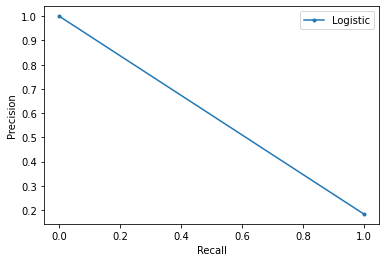

In [425]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, matthews_corrcoef
import numpy as np
from matplotlib import pyplot

y_predict = np.asarray(flat_predictions)
y_test = np.asarray(flat_true_labels)
print(confusion_matrix(y_test,y_predict))
recall=recall_score(y_test,y_predict,average='macro')
precision=precision_score(y_test,y_predict,average='macro')
f1score=f1_score(y_test,y_predict,average='macro')
accuracy=accuracy_score(y_test,y_predict)
print('Accuracy: '+ str(accuracy))
print('Macro Precision: '+ str(precision))
print('Macro Recall: '+ str(recall))
print('Macro F1 score:'+ str(f1score))

lr_precision, lr_recall, _ = precision_recall_curve(flat_true_labels,flat_predictions)
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

### On first 1000 Compvis labels using BERT and lemma tokenizer

In [426]:
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 16

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')

# Creating attention masks
attention_masks = []

for id in input_ids:
    
    # Creating the attention mask.
    #   - If a token ID is 0, set the mask to 0.
    #   - If a token ID is > 0, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in id]
    
    attention_masks.append(att_mask)


Padding/truncating all sentences to 16 values...

Done.


In [427]:
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, CompVisLabels, 
                                                            random_state=2018, test_size=0.1)
#Doing the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, CompVisLabels,
                                             random_state=2018, test_size=0.1)
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#defining batch size
batch_size = 32

#DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

#DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [428]:
start_time = time.time()
import random

seed_val = 100

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the avg loss after each epoch.
loss_values = []

for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_loss = 0

    model.train()

    # For each batch of training data
    for step, batch in enumerate(train_dataloader):

        #Progress update every 5 batches.
        if step % 5 == 0 and not step == 0:
            #Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

       
        # batch contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
#         print("b_input_ids",len(b_input_ids),type(b_input_ids))
#         print(b_input_ids.shape)
#         print("b_input_mask",len(b_input_mask),type(b_input_mask))
#         print(b_input_mask.shape)
#         print("b_labels",len(b_labels),type(b_labels))
#         print(b_labels.shape)

        model.zero_grad()        

        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        loss = outputs[0]

        total_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)            
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()
 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    for batch in validation_dataloader:
        
        batch = tuple(t.to(device) for t in batch)
        
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients..
        with torch.no_grad():        

            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculating the accuracy for this batch
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        eval_accuracy += tmp_eval_accuracy

        nb_eval_steps += 1

    # Reporting the final accuracy for the validation.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")
print("--- %s seconds ---" % (time.time() - start_time))


======== Epoch 1 / 1 ========
Training...
  Batch     5  of     29.    Elapsed: 0:00:30.
  Batch    10  of     29.    Elapsed: 0:00:56.
  Batch    15  of     29.    Elapsed: 0:01:17.
  Batch    20  of     29.    Elapsed: 0:01:40.
  Batch    25  of     29.    Elapsed: 0:01:59.

  Average training loss: 0.20
  Training epcoh took: 0:02:14

Running Validation...
  Accuracy: 1.00
  Validation took: 0:00:04

Training complete!
--- 138.37577319145203 seconds ---


In [351]:
# from keras.preprocessing.sequence import pad_sequences

# MAX_LEN = 16

# print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

# input_ids = pad_sequences(input_ids_test, maxlen=MAX_LEN, dtype="long", 
#                           value=0, truncating="post", padding="post")

# print('\nDone.')

# # Creating attention masks
# attention_masks = []

# for id in input_ids_test:
    
#     # Creating the attention mask.
#     #   - If a token ID is 0, set the mask to 0.
#     #   - If a token ID is > 0, set the mask to 1.
#     att_mask = [int(token_id > 0) for token_id in id]
    
#     attention_masks.append(att_mask)


Padding/truncating all sentences to 16 values...

Done.


In [429]:
labels = df_test.CompVis.values

input_ids_test = pad_sequences(input_ids_test, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

attention_masks_test = []

for seq in input_ids_test:
  seq_mask = [float(i>0) for i in seq]
  attention_masks_test.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids_test)
prediction_masks = torch.tensor(attention_masks_test)
prediction_labels = torch.tensor(labels)

batch_size = 32  

prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [430]:
# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

model.eval()

predictions , true_labels = [], []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)

  b_input_ids, b_input_mask, b_labels = batch
  

  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  predictions.append(logits)
  true_labels.append(label_ids)

print('done.')

Predicting labels for 19,678 test sentences...
done.


In [431]:
# Combine the predictions for each batch into a list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

accuracy = accuracy_score(flat_true_labels, flat_predictions)
print('Accuray: %.3f' % accuracy)

Accuray: 0.891


[[17526     0]
 [ 2152     0]]
Accuracy: 0.8906392926110377
Macro Precision: 0.44531964630551885
Macro Recall: 0.5
Macro F1 score:0.4710783786689603


/Users/chaitanyamuvva/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


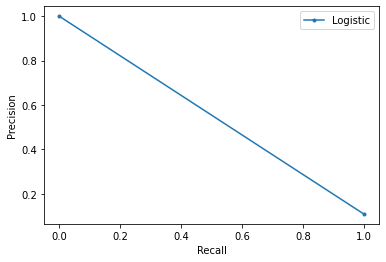

In [432]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, matthews_corrcoef
import numpy as np
from matplotlib import pyplot

y_predict = np.asarray(flat_predictions)
y_test = np.asarray(flat_true_labels)
print(confusion_matrix(y_test,y_predict))
recall=recall_score(y_test,y_predict,average='macro')
precision=precision_score(y_test,y_predict,average='macro')
f1score=f1_score(y_test,y_predict,average='macro')
accuracy=accuracy_score(y_test,y_predict)
print('Accuracy: '+ str(accuracy))
print('Macro Precision: '+ str(precision))
print('Macro Recall: '+ str(recall))
print('Macro F1 score:'+ str(f1score))

lr_precision, lr_recall, _ = precision_recall_curve(flat_true_labels,flat_predictions)
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

### On first 1000 Math labels using BERT and lemma tokenizer..

In [433]:
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 16

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')

# Creating attention masks
attention_masks = []

for id in input_ids:
    
    # Creating the attention mask.
    #   - If a token ID is 0, set the mask to 0.
    #   - If a token ID is > 0, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in id]
    
    attention_masks.append(att_mask)


Padding/truncating all sentences to 16 values...

Done.


In [434]:
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, MathLabels, 
                                                            random_state=2018, test_size=0.1)
#Doing the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, MathLabels,
                                             random_state=2018, test_size=0.1)
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#defining batch size
batch_size = 32

#DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

#DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [435]:
start_time = time.time()
import random

seed_val = 100

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the avg loss after each epoch.
loss_values = []

for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_loss = 0

    model.train()

    # For each batch of training data
    for step, batch in enumerate(train_dataloader):

        #Progress update every 5 batches.
        if step % 5 == 0 and not step == 0:
            #Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

       
        # batch contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
#         print("b_input_ids",len(b_input_ids),type(b_input_ids))
#         print(b_input_ids.shape)
#         print("b_input_mask",len(b_input_mask),type(b_input_mask))
#         print(b_input_mask.shape)
#         print("b_labels",len(b_labels),type(b_labels))
#         print(b_labels.shape)

        model.zero_grad()        

        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        loss = outputs[0]

        total_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)            
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()
 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    for batch in validation_dataloader:
        
        batch = tuple(t.to(device) for t in batch)
        
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients..
        with torch.no_grad():        

            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculating the accuracy for this batch
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        eval_accuracy += tmp_eval_accuracy

        nb_eval_steps += 1

    # Reporting the final accuracy for the validation.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")
print("--- %s seconds ---" % (time.time() - start_time))


======== Epoch 1 / 1 ========
Training...
  Batch     5  of     29.    Elapsed: 0:00:26.
  Batch    10  of     29.    Elapsed: 0:00:47.
  Batch    15  of     29.    Elapsed: 0:01:08.
  Batch    20  of     29.    Elapsed: 0:01:29.
  Batch    25  of     29.    Elapsed: 0:01:51.

  Average training loss: 0.23
  Training epcoh took: 0:02:05

Running Validation...
  Accuracy: 0.98
  Validation took: 0:00:03

Training complete!
--- 128.23313784599304 seconds ---


In [357]:
# from keras.preprocessing.sequence import pad_sequences

# MAX_LEN = 16

# print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

# input_ids = pad_sequences(input_ids_test, maxlen=MAX_LEN, dtype="long", 
#                           value=0, truncating="post", padding="post")

# print('\nDone.')

# # Creating attention masks
# attention_masks = []

# for id in input_ids_test:
    
#     # Creating the attention mask.
#     #   - If a token ID is 0, set the mask to 0.
#     #   - If a token ID is > 0, set the mask to 1.
#     att_mask = [int(token_id > 0) for token_id in id]
    
#     attention_masks.append(att_mask)


Padding/truncating all sentences to 16 values...

Done.


In [436]:
labels = df_test.Math.values
MAX_LEN = 16

input_ids_test = pad_sequences(input_ids_test, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

attention_masks_test = []

for seq in input_ids_test:
  seq_mask = [float(i>0) for i in seq]
  attention_masks_test.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids_test)
prediction_masks = torch.tensor(attention_masks_test)
prediction_labels = torch.tensor(labels)

batch_size = 32  

prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [437]:
# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

model.eval()

predictions , true_labels = [], []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)

  b_input_ids, b_input_mask, b_labels = batch
  

  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  predictions.append(logits)
  true_labels.append(label_ids)

print('done.')

Predicting labels for 19,678 test sentences...
done.


In [438]:
# Combine the predictions for each batch into a list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

accuracy = accuracy_score(flat_true_labels, flat_predictions)
print('Accuray: %.3f' % accuracy)

Accuray: 0.699


[[13748     0]
 [ 5930     0]]
Accuracy: 0.6986482366094116
Macro Precision: 0.3493241183047058
Macro Recall: 0.5
Macro F1 score:0.4112965954646084


/Users/chaitanyamuvva/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


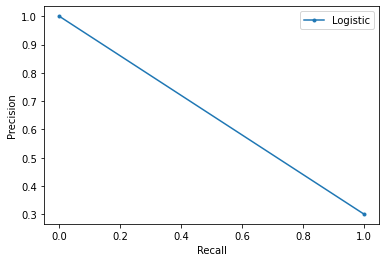

In [439]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, matthews_corrcoef
import numpy as np
from matplotlib import pyplot

y_predict = np.asarray(flat_predictions)
y_test = np.asarray(flat_true_labels)
print(confusion_matrix(y_test,y_predict))
recall=recall_score(y_test,y_predict,average='macro')
precision=precision_score(y_test,y_predict,average='macro')
f1score=f1_score(y_test,y_predict,average='macro')
accuracy=accuracy_score(y_test,y_predict)
print('Accuracy: '+ str(accuracy))
print('Macro Precision: '+ str(precision))
print('Macro Recall: '+ str(recall))
print('Macro F1 score:'+ str(f1score))

lr_precision, lr_recall, _ = precision_recall_curve(flat_true_labels,flat_predictions)
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## Using BERT and LemmaTokenizer for all the InfoTheory Labels

In [ ]:
trainDocs = df_train.Abstract.tolist()
InfoTheoryLabels = df_train.InfoTheory.tolist()
CompVisLabels = df_train.CompVis.tolist()
MathLabels = df_train.Math.tolist()

testDocs = df_test.Abstract.tolist()
InfoTheory_testLabels = df_test.InfoTheory.tolist()
CompVis_testLabels = df_test.CompVis.tolist()
Math_testLabels = df_test.Math.tolist()

x_train=vectorizer.fit_transform(trainDocs)
x_test=vectorizer.transform(testDocs)

x_train = x_train.todense().tolist()
x_test = x_test.todense().tolist()

# Adding encoded values of [CLS] and [SEP] as 101 and 102 in the first and last place respectively..

for i in x_train:
    i.insert(0,101)
    i.insert(10367,102)

len(x_train)

for i in x_test:
    i.insert(0,101)
    i.insert(10367,102)

len(x_test)

# len(x_test[0])

input_ids = x_train
input_ids_test = x_test

len(input_ids)

from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 16

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')

# Creating attention masks
attention_masks = []

for id in input_ids:
    
    # Creating the attention mask.
    #   - If a token ID is 0, set the mask to 0.
    #   - If a token ID is > 0, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in id]
    
    attention_masks.append(att_mask)

len(input_ids)

from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, InfoTheoryLabels, 
                                                            random_state=2018, test_size=0.1)
#Doing the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, InfoTheoryLabels,
                                             random_state=2018, test_size=0.1)
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#defining batch size
batch_size = 32

#DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

#DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

start_time = time.time()
import random

seed_val = 100

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the avg loss after each epoch.
loss_values = []

for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_loss = 0

    model.train()

    # For each batch of training data
    for step, batch in enumerate(train_dataloader):

        #Progress update every 5 batches.
        if step % 5 == 0 and not step == 0:
            #Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

       
        # batch contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        loss = outputs[0]

        total_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)            
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()
 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    for batch in validation_dataloader:
        
        batch = tuple(t.to(device) for t in batch)
        
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients..
        with torch.no_grad():        

            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculating the accuracy for this batch
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        eval_accuracy += tmp_eval_accuracy

        nb_eval_steps += 1

    # Reporting the final accuracy for the validation.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")
print("--- %s seconds ---" % (time.time() - start_time))

labels = df_test.InfoTheory.values

input_ids_test = pad_sequences(input_ids_test, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

attention_masks_test = []

for seq in input_ids_test:
  seq_mask = [float(i>0) for i in seq]
  attention_masks_test.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids_test)
prediction_masks = torch.tensor(attention_masks_test)
prediction_labels = torch.tensor(labels)

batch_size = 32  

prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

model.eval()

predictions , true_labels = [], []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)

  b_input_ids, b_input_mask, b_labels = batch
  

  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  predictions.append(logits)
  true_labels.append(label_ids)

print('done.')

# Combine the predictions for each batch into a list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

accuracy = accuracy_score(flat_true_labels, flat_predictions)
print('Accuray: %.3f' % accuracy)

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, matthews_corrcoef
import numpy as np
from matplotlib import pyplot

y_predict = np.asarray(flat_predictions)
y_test = np.asarray(flat_true_labels)
print(confusion_matrix(y_test,y_predict))
recall=recall_score(y_test,y_predict,average='macro')
precision=precision_score(y_test,y_predict,average='macro')
f1score=f1_score(y_test,y_predict,average='macro')
accuracy=accuracy_score(y_test,y_predict)
print('Accuracy: '+ str(accuracy))
print('Macro Precision: '+ str(precision))
print('Macro Recall: '+ str(recall))
print('Macro F1 score:'+ str(f1score))

lr_precision, lr_recall, _ = precision_recall_curve(flat_true_labels,flat_predictions)
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()


## Using BERT and lemma tokenizer for all the CompVis Labels

In [ ]:
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 16

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')

# Creating attention masks
attention_masks = []

for id in input_ids:
    
    # Creating the attention mask.
    #   - If a token ID is 0, set the mask to 0.
    #   - If a token ID is > 0, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in id]
    
    attention_masks.append(att_mask)

from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, CompVisLabels, 
                                                            random_state=2018, test_size=0.1)
#Doing the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, CompVisLabels,
                                             random_state=2018, test_size=0.1)
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#defining batch size
batch_size = 32

#DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

#DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

start_time = time.time()
import random

seed_val = 100

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the avg loss after each epoch.
loss_values = []

for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_loss = 0

    model.train()

    # For each batch of training data
    for step, batch in enumerate(train_dataloader):

        #Progress update every 5 batches.
        if step % 5 == 0 and not step == 0:
            #Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

       
        # batch contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        loss = outputs[0]

        total_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)            
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()
 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    for batch in validation_dataloader:
        
        batch = tuple(t.to(device) for t in batch)
        
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients..
        with torch.no_grad():        

            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculating the accuracy for this batch
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        eval_accuracy += tmp_eval_accuracy

        nb_eval_steps += 1

    # Reporting the final accuracy for the validation.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")
print("--- %s seconds ---" % (time.time() - start_time))



MAX_LEN = 16

labels = df_test.CompVis.values

input_ids_test = pad_sequences(input_ids_test, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

attention_masks_test = []

for seq in input_ids_test:
  seq_mask = [float(i>0) for i in seq]
  attention_masks_test.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids_test)
prediction_masks = torch.tensor(attention_masks_test)
prediction_labels = torch.tensor(labels)

batch_size = 32  

prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

model.eval()

predictions , true_labels = [], []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)

  b_input_ids, b_input_mask, b_labels = batch
  

  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  predictions.append(logits)
  true_labels.append(label_ids)

print('done.')

# Combine the predictions for each batch into a list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

accuracy = accuracy_score(flat_true_labels, flat_predictions)
print('Accuray: %.3f' % accuracy)

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, matthews_corrcoef
import numpy as np
from matplotlib import pyplot

y_predict = np.asarray(flat_predictions)
y_test = np.asarray(flat_true_labels)
print(confusion_matrix(y_test,y_predict))
recall=recall_score(y_test,y_predict,average='macro')
precision=precision_score(y_test,y_predict,average='macro')
f1score=f1_score(y_test,y_predict,average='macro')
accuracy=accuracy_score(y_test,y_predict)
print('Accuracy: '+ str(accuracy))
print('Macro Precision: '+ str(precision))
print('Macro Recall: '+ str(recall))
print('Macro F1 score:'+ str(f1score))

lr_precision, lr_recall, _ = precision_recall_curve(flat_true_labels,flat_predictions)
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## Using BERT and lemma tokenizer on all the Math Labels

In [ ]:
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 16

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')

# Creating attention masks
attention_masks = []

for id in input_ids:
    
    # Creating the attention mask.
    #   - If a token ID is 0, set the mask to 0.
    #   - If a token ID is > 0, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in id]
    
    attention_masks.append(att_mask)

from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, MathLabels, 
                                                            random_state=2018, test_size=0.1)
#Doing the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, MathLabels,
                                             random_state=2018, test_size=0.1)
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#defining batch size
batch_size = 32

#DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

#DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

start_time = time.time()
import random

seed_val = 100

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the avg loss after each epoch.
loss_values = []

for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_loss = 0

    model.train()

    # For each batch of training data
    for step, batch in enumerate(train_dataloader):

        #Progress update every 5 batches.
        if step % 5 == 0 and not step == 0:
            #Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

       
        # batch contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
#         print("b_input_ids",len(b_input_ids),type(b_input_ids))
#         print(b_input_ids.shape)
#         print("b_input_mask",len(b_input_mask),type(b_input_mask))
#         print(b_input_mask.shape)
#         print("b_labels",len(b_labels),type(b_labels))
#         print(b_labels.shape)

        model.zero_grad()        

        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        loss = outputs[0]

        total_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)            
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()
 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    for batch in validation_dataloader:
        
        batch = tuple(t.to(device) for t in batch)
        
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients..
        with torch.no_grad():        

            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculating the accuracy for this batch
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        eval_accuracy += tmp_eval_accuracy

        nb_eval_steps += 1

    # Reporting the final accuracy for the validation.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")
print("--- %s seconds ---" % (time.time() - start_time))

labels = df_test.Math.values
MAX_LEN = 16

input_ids_test = pad_sequences(input_ids_test, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

attention_masks_test = []

for seq in input_ids_test:
  seq_mask = [float(i>0) for i in seq]
  attention_masks_test.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids_test)
prediction_masks = torch.tensor(attention_masks_test)
prediction_labels = torch.tensor(labels)

batch_size = 32  

prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

model.eval()

predictions , true_labels = [], []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)

  b_input_ids, b_input_mask, b_labels = batch
  

  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  predictions.append(logits)
  true_labels.append(label_ids)

print('done.')

# Combine the predictions for each batch into a list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

accuracy = accuracy_score(flat_true_labels, flat_predictions)
print('Accuray: %.3f' % accuracy)

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, matthews_corrcoef
import numpy as np
from matplotlib import pyplot

y_predict = np.asarray(flat_predictions)
y_test = np.asarray(flat_true_labels)
print(confusion_matrix(y_test,y_predict))
recall=recall_score(y_test,y_predict,average='macro')
precision=precision_score(y_test,y_predict,average='macro')
f1score=f1_score(y_test,y_predict,average='macro')
accuracy=accuracy_score(y_test,y_predict)
print('Accuracy: '+ str(accuracy))
print('Macro Precision: '+ str(precision))
print('Macro Recall: '+ str(recall))
print('Macro F1 score:'+ str(f1score))

lr_precision, lr_recall, _ = precision_recall_curve(flat_true_labels,flat_predictions)
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## Using Statistical model

In [86]:
%matplotlib inline

from nltk.corpus import stopwords
from nltk import word_tokenize    
from nltk.tokenize import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, matthews_corrcoef
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB,BernoulliNB
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
#from sklearn import cross_validation
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
#!pip3 install seaborn

In [4]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df_train = pd.read_csv(".//assignment1_data/axcs_train.csv", delimiter=',')
df_test = pd.read_csv(".//assignment1_data/axcs_test.csv", delimiter=',')

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df_train.shape[0]))
print('Number of testing sentences: {:,}\n'.format(df_test.shape[0]))

Number of training sentences: 54,731

Number of testing sentences: 19,678



In [5]:
df_train.sample(5)

,ID,URL,Date,Title,InfoTheory,CompVis,Math,Abstract
42829,no-13125952,arxiv.org/abs/1312.5952,2013-12-20,Proceedings of the Fourth International Worksh...,0,0,0,Proceedings of the Fourth International Works...
39914,no-13093201,arxiv.org/abs/1309.3201,2013-09-12,On topological and geometric $(19_4)$ configur...,0,0,1,On topological and geometric configurations A...
29401,no-12082405,arxiv.org/abs/1208.2405,2012-08-12,Routing Load of Route Discovery and Route Main...,0,0,0,Routing Load of Route Discovery and Route Mai...
26138,no-12022561,arxiv.org/abs/1202.2561,2012-04-03,On the Diversity Gain Region of the Z-interfer...,1,0,1,On the Diversity Gain Region of the Z-interfe...
51138,no-14093367,arxiv.org/abs/1409.3367,2014-09-11,HTML5 WebSocket protocol and its application t...,0,0,0,HTML5 WebSocket protocol and its application ...


### Using LemmaTokenizer with all the records

In [130]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl=WordNetLemmatizer()
    def __call__(self,doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

In [131]:
vectorizer=TfidfVectorizer(analyzer='word',input='content',
                           lowercase=True,
                           token_pattern='(?u)\\b\\w\\w+\\b',
                           min_df=3,
                           ngram_range=(1,2),
                           tokenizer=LemmaTokenizer())

In [133]:
import nltk
# nltk.download('punkt')
# nltk.download('wordnet')

In [200]:
trainDocs = df_train.Abstract.tolist() 
InfoTheoryLabels = df_train.InfoTheory.tolist() 
CompVisLabels = df_train.CompVis.tolist()
MathLabels = df_train.Math.tolist()

In [201]:
print(len(trainDocs))

54731


In [202]:
x_train=vectorizer.fit_transform(trainDocs)
y_train=np.asarray(InfoTheoryLabels)

In [203]:
len(vectorizer.get_feature_names())

309348

In [204]:
vectorizer.get_feature_names()

['!',
 '! )',
 '! ,',
 '! -',
 '! :',
 '! =',
 '! =np',
 '! a',
 '! and',
 '! in',
 '! possible',
 '! the',
 '! this',
 '! we',
 '! }',
 '#',
 '# ,',
 '# .',
 '# 1',
 '# 64257',
 '# 8211',
 '# 8217',
 '# and',
 '# bi',
 '# csp',
 '# csps',
 '# p',
 '# p-complete',
 '# p-completeness',
 '# p-hard',
 '# p.',
 '# rhpi_1',
 '# sat',
 '$',
 '$ $',
 '$ (',
 '$ ,',
 '$ .',
 '$ \\varphi\\in\\alpha',
 '$ are',
 '$ is',
 '$ we',
 '$ {',
 '%',
 '% (',
 '% )',
 '% +/-',
 '% ,',
 '% -',
 '% -30',
 '% .',
 '% ;',
 '% a',
 '% accuracy',
 '% accurate',
 '% and',
 '% are',
 '% area',
 '% at',
 '% average',
 '% better',
 '% by',
 '% can',
 '% character',
 '% classification',
 '% compared',
 '% confidence',
 '% correct',
 '% coverage',
 '% decrease',
 '% depending',
 '% detection',
 '% drop',
 '% efficiency',
 '% energy',
 '% enhancement',
 '% error',
 '% even',
 '% false',
 '% faster',
 '% fewer',
 '% first',
 '% for',
 '% from',
 '% gain',
 '% have',
 '% higher',
 '% improvement',
 '% in',
 '% increase

In [205]:
testDocs = df_test.Abstract.tolist() 
InfoTheory_testLabels = df_test.InfoTheory.tolist() 
CompVis_testLabels = df_test.CompVis.tolist()
Math_testLabels = df_test.Math.tolist()

In [206]:
x_test=vectorizer.transform(testDocs)
y_test=np.asarray(InfoTheory_testLabels)


In [207]:
models = [
    LogisticRegression()
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
     model_name = model.__class__.__name__
     accuracies = cross_val_score(model, x_train, y_train, scoring='accuracy', cv=CV)
     for fold_idx, accuracy in enumerate(accuracies):
          entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

## Logistic Regression on all the records of InfoTheory using Lemma Tokenizer

In [208]:
models = [
    LogisticRegression()
]

for clf in models:
    model_name = clf.__class__.__name__
    clf.fit(x_train, y_train)
    print(model_name)
    # Do the prediction
    y_predict=clf.predict(x_test)
    print(confusion_matrix(y_test,y_predict))
    recall=recall_score(y_test,y_predict,average='macro')
    precision=precision_score(y_test,y_predict,average='macro')
    f1score=f1_score(y_test,y_predict,average='macro')
    accuracy=accuracy_score(y_test,y_predict)
    matthews = matthews_corrcoef(y_test,y_predict) 
    print('Accuracy: '+ str(accuracy))
    print('Macro Precision: '+ str(precision))
    print('Macro Recall: '+ str(recall))
    print('Macro F1 score:'+ str(f1score))
    print('MCC:'+ str(matthews))

LogisticRegression
[[15906   156]
 [  872  2744]]
Accuracy: 0.9477589185892875
Macro Precision: 0.9471170374998459
Macro Recall: 0.8745685964674497
Macro F1 score:0.9054656055103563
MCC:0.8184766366683934


## Logistic Regression on all the CompVis records using Lemma Tokenizer

In [209]:
y_train = np.asarray(CompVisLabels)
y_test = np.asarray(CompVis_testLabels)

In [210]:
models = [
    LogisticRegression()
]
for clf in models:
    model_name = clf.__class__.__name__
    clf.fit(x_train, y_train)
    print(model_name)
    # Do the prediction
    y_predict=clf.predict(x_test)
    print(confusion_matrix(y_test,y_predict))
    recall=recall_score(y_test,y_predict,average='macro')
    precision=precision_score(y_test,y_predict,average='macro')
    f1score=f1_score(y_test,y_predict,average='macro')
    accuracy=accuracy_score(y_test,y_predict)
    matthews = matthews_corrcoef(y_test,y_predict) 
    print('Accuracy: '+ str(accuracy))
    print('Macro Precision: '+ str(precision))
    print('Macro Recall: '+ str(recall))
    print('Macro F1 score:'+ str(f1score))
    print('MCC:'+ str(matthews))

LogisticRegression
[[17470    56]
 [  899  1253]]
Accuracy: 0.9514686451875191
Macro Precision: 0.9541390502424598
Macro Recall: 0.7895269089323266
Macro F1 score:0.8487314057957174
MCC:0.7252185200121738


## Logistic Regression on all the Math records using Lemma Tokenizer

In [211]:
y_train = np.asarray(MathLabels)
y_test = np.asarray(Math_testLabels)

In [212]:
models = [
    LogisticRegression()
]
for clf in models:
    model_name = clf.__class__.__name__
    clf.fit(x_train, y_train)
    print(model_name)
    # Do the prediction
    y_predict=clf.predict(x_test)
    print(confusion_matrix(y_test,y_predict))
    recall=recall_score(y_test,y_predict,average='macro')
    precision=precision_score(y_test,y_predict,average='macro')
    f1score=f1_score(y_test,y_predict,average='macro')
    accuracy=accuracy_score(y_test,y_predict)
    matthews = matthews_corrcoef(y_test,y_predict) 
    print('Accuracy: '+ str(accuracy))
    print('Macro Precision: '+ str(precision))
    print('Macro Recall: '+ str(recall))
    print('Macro F1 score:'+ str(f1score))
    print('MCC:'+ str(matthews))

LogisticRegression
[[13039   709]
 [ 1747  4183]]
Accuracy: 0.8751905681471694
Macro Precision: 0.868458597495432
Macro Recall: 0.8269125762152865
Macro F1 score:0.8434910664406337
MCC:0.6941289486425499


/Users/chaitanyamuvva/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Considering all the InfoTheory records using Bert Tokenizer and Statistical model..

In [137]:
from transformers import BertTokenizer

# Loading the BERT tokenizer.
print('Loading BERT tokenizer')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer


In [139]:
#Infotheory labels
y_train = np.asarray(InfoTheoryLabels)
y_test = np.asarray(InfoTheory_testLabels)

In [141]:
input_ids = []

for abstract in trainDocs:
    encoded_abstract = tokenizer.encode(
                        abstract,                      # Sentence to encode.
                        add_special_tokens = False, # Add '[CLS]' and '[SEP]'
                        max_length = 745,
                   )
    
    # Adding the encoded sentence to the list
    input_ids.append(encoded_abstract)

In [142]:
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 16 #performing truncate

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))


input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')


Padding/truncating all sentences to 16 values...

Padding token: "[PAD]", ID: 0

Done.


In [143]:
x_train = input_ids

In [144]:
input_ids = []

for abstract in testDocs:
    encoded_abstract = tokenizer.encode(
                        abstract,                      # Sentence to encode.
                        add_special_tokens = False, # Add '[CLS]' and '[SEP]'
                        max_length = 745,
                   )
    
    # Adding the encoded sentence to the list
    input_ids.append(encoded_abstract)

In [145]:
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 16 #performing truncate

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))


input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')


Padding/truncating all sentences to 16 values...

Padding token: "[PAD]", ID: 0

Done.


In [146]:
x_test = input_ids

LogisticRegression
[[16062     0]
 [ 3616     0]]
Accuracy: 0.8162414879560931
Macro Precision: 0.40812074397804654
Macro Recall: 0.5
Macro F1 score:0.44941242305540013


/Users/chaitanyamuvva/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chaitanyamuvva/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


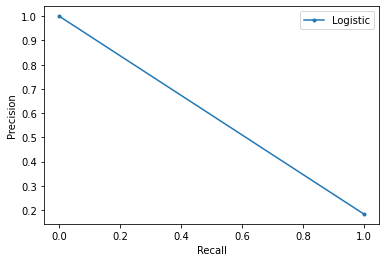

In [147]:
models = [
    LogisticRegression()
]

for clf in models:
    model_name = clf.__class__.__name__
    clf.fit(x_train, y_train)
    print(model_name)
    # Do the prediction
    y_predict=clf.predict(x_test)
    print(confusion_matrix(y_test,y_predict))
    recall=recall_score(y_test,y_predict,average='macro')
    precision=precision_score(y_test,y_predict,average='macro')
    f1score=f1_score(y_test,y_predict,average='macro')
    accuracy=accuracy_score(y_test,y_predict)
    matthews = matthews_corrcoef(y_test,y_predict) 
    print('Accuracy: '+ str(accuracy))
    print('Macro Precision: '+ str(precision))
    print('Macro Recall: '+ str(recall))
    print('Macro F1 score:'+ str(f1score))
lr_precision, lr_recall, _ = precision_recall_curve(y_test,y_predict)
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## Considering all the CompVis records using Bert Tokenizer and Statistical model..

In [148]:
#For CompVisLabels
y_train = np.asarray(CompVisLabels)
y_test = np.asarray(CompVis_testLabels)

LogisticRegression
[[17526     0]
 [ 2152     0]]
Accuracy: 0.8906392926110377
Macro Precision: 0.44531964630551885
Macro Recall: 0.5
Macro F1 score:0.4710783786689603


/Users/chaitanyamuvva/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chaitanyamuvva/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


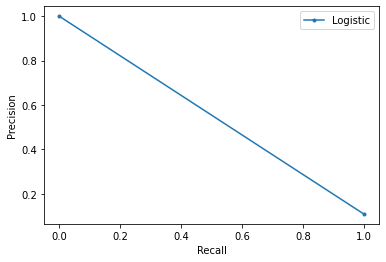

In [149]:
models = [
    LogisticRegression()
]

for clf in models:
    model_name = clf.__class__.__name__
    clf.fit(x_train, y_train)
    print(model_name)
    # Do the prediction
    y_predict=clf.predict(x_test)
    print(confusion_matrix(y_test,y_predict))
    recall=recall_score(y_test,y_predict,average='macro')
    precision=precision_score(y_test,y_predict,average='macro')
    f1score=f1_score(y_test,y_predict,average='macro')
    accuracy=accuracy_score(y_test,y_predict)
    matthews = matthews_corrcoef(y_test,y_predict) 
    print('Accuracy: '+ str(accuracy))
    print('Macro Precision: '+ str(precision))
    print('Macro Recall: '+ str(recall))
    print('Macro F1 score:'+ str(f1score))
lr_precision, lr_recall, _ = precision_recall_curve(y_test,y_predict)
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## Considering all the Math records using Bert Tokenizer and Statistical model..

In [150]:
#Math labels
y_train = np.asarray(MathLabels)
y_test = np.asarray(Math_testLabels)

LogisticRegression
[[13748     0]
 [ 5930     0]]
Accuracy: 0.6986482366094116
Macro Precision: 0.3493241183047058
Macro Recall: 0.5
Macro F1 score:0.4112965954646084


/Users/chaitanyamuvva/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chaitanyamuvva/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


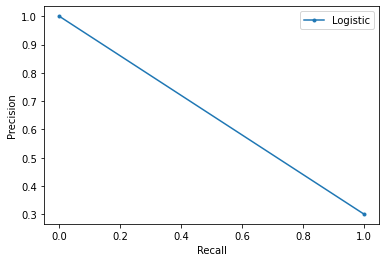

In [151]:
models = [
    LogisticRegression()
]

for clf in models:
    model_name = clf.__class__.__name__
    clf.fit(x_train, y_train)
    print(model_name)
    # Do the prediction
    y_predict=clf.predict(x_test)
    print(confusion_matrix(y_test,y_predict))
    recall=recall_score(y_test,y_predict,average='macro')
    precision=precision_score(y_test,y_predict,average='macro')
    f1score=f1_score(y_test,y_predict,average='macro')
    accuracy=accuracy_score(y_test,y_predict)
    matthews = matthews_corrcoef(y_test,y_predict) 
    print('Accuracy: '+ str(accuracy))
    print('Macro Precision: '+ str(precision))
    print('Macro Recall: '+ str(recall))
    print('Macro F1 score:'+ str(f1score))
lr_precision, lr_recall, _ = precision_recall_curve(y_test,y_predict)
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [175]:
trainDocs = df_train.Abstract.tolist()[:1000]
InfoTheoryLabels = df_train.InfoTheory.tolist()[:1000]
CompVisLabels = df_train.CompVis.tolist()[:1000]
MathLabels = df_train.Math.tolist()[:1000]

## Considering first 1000 InfoTheory records using LemmaTokenizer and Statistical model

In [176]:
trainDocs = df_train.Abstract.tolist()[:1000]
InfoTheoryLabels = df_train.InfoTheory.tolist() [:1000]
CompVisLabels = df_train.CompVis.tolist()[:1000]
MathLabels = df_train.Math.tolist()[:1000]
# print(len(InfoTheoryLabels))

In [177]:
# testDocs = df_test.Abstract.tolist()[:1000]
# InfoTheory_testLabels = df_test.InfoTheory.tolist()[:1000]
# CompVis_testLabels = df_test.CompVis.tolist()[:1000]
# Math_testLabels = df_test.Math.tolist()[:1000]

# testDocs = df_test.Abstract.tolist()
# InfoTheory_testLabels = df_test.InfoTheory.tolist()
# CompVis_testLabels = df_test.CompVis.tolist()
# Math_testLabels = df_test.Math.tolist()

In [178]:
x_train=vectorizer.fit_transform(trainDocs)
x_test=vectorizer.transform(testDocs)

In [179]:
trainDocs

[' Nested satisfiability A special case of the satisfiability problem, in which the clauses have a hierarchical structure, is shown to be solvable in linear time, assuming that the clauses have been represented in a convenient way. ',
 ' A note on digitized angles We study the configurations of pixels that occur when two digitized straight lines meet each other. ',
 " Textbook examples of recursion We discuss properties of recursive schemas related to McCarthy's ``91 function'' and to Takeuchi's triple recursion. Several theorems are proposed as interesting candidates for machine verification, and some intriguing open questions are raised. ",
 ' Theory and practice The author argues to Silicon Valley that the most important and powerful part of computer science is work that is simultaneously theoretical and practical. He particularly considers the intersection of the theory of algorithms and practical software development. He combines examples from the development of the TeX typesettin

In [180]:
y_train = np.asarray(InfoTheoryLabels)
y_test = np.asarray(InfoTheory_testLabels)

LogisticRegression
[[16062     0]
 [ 3616     0]]
Accuracy: 0.8162414879560931
Macro Precision: 0.40812074397804654
Macro Recall: 0.5
Macro F1 score:0.44941242305540013


/Users/chaitanyamuvva/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chaitanyamuvva/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


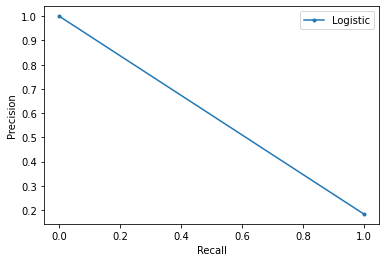

In [181]:
models = [
    LogisticRegression()
]

for clf in models:
    model_name = clf.__class__.__name__
    clf.fit(x_train, y_train)
    print(model_name)
    # Do the prediction
    y_predict=clf.predict(x_test)
    print(confusion_matrix(y_test,y_predict))
    recall=recall_score(y_test,y_predict,average='macro')
    precision=precision_score(y_test,y_predict,average='macro')
    f1score=f1_score(y_test,y_predict,average='macro')
    accuracy=accuracy_score(y_test,y_predict)
    matthews = matthews_corrcoef(y_test,y_predict) 
    print('Accuracy: '+ str(accuracy))
    print('Macro Precision: '+ str(precision))
    print('Macro Recall: '+ str(recall))
    print('Macro F1 score:'+ str(f1score))
    
lr_precision, lr_recall, _ = precision_recall_curve(y_test,y_predict)
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## Considering first 1000 CompVis records using LemmaTokenizer and Statistical model..

In [182]:
y_train = np.asarray(CompVisLabels)
y_test = np.asarray(CompVis_testLabels)

LogisticRegression
[[17526     0]
 [ 2152     0]]
Accuracy: 0.8906392926110377
Macro Precision: 0.44531964630551885
Macro Recall: 0.5
Macro F1 score:0.4710783786689603


/Users/chaitanyamuvva/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chaitanyamuvva/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


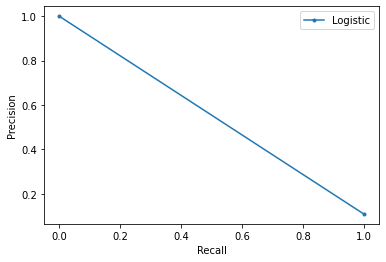

In [183]:
models = [
    LogisticRegression()
]

for clf in models:
    model_name = clf.__class__.__name__
    clf.fit(x_train, y_train)
    print(model_name)
    # Do the prediction
    y_predict=clf.predict(x_test)
    print(confusion_matrix(y_test,y_predict))
    recall=recall_score(y_test,y_predict,average='macro')
    precision=precision_score(y_test,y_predict,average='macro')
    f1score=f1_score(y_test,y_predict,average='macro')
    accuracy=accuracy_score(y_test,y_predict)
    matthews = matthews_corrcoef(y_test,y_predict) 
    print('Accuracy: '+ str(accuracy))
    print('Macro Precision: '+ str(precision))
    print('Macro Recall: '+ str(recall))
    print('Macro F1 score:'+ str(f1score))
lr_precision, lr_recall, _ = precision_recall_curve(y_test,y_predict)
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## Considering first 1000 Math records using LemmaTokenizer and Statistical model

In [185]:
y_train = np.asarray(MathLabels)
y_test = np.asarray(Math_testLabels)

LogisticRegression
[[13748     0]
 [ 5930     0]]
Accuracy: 0.6986482366094116
Macro Precision: 0.3493241183047058
Macro Recall: 0.5
Macro F1 score:0.4112965954646084


/Users/chaitanyamuvva/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chaitanyamuvva/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


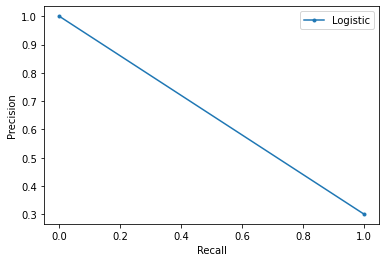

In [186]:
models = [
    LogisticRegression()
]

for clf in models:
    model_name = clf.__class__.__name__
    clf.fit(x_train, y_train)
    print(model_name)
    # Do the prediction
    y_predict=clf.predict(x_test)
    print(confusion_matrix(y_test,y_predict))
    recall=recall_score(y_test,y_predict,average='macro')
    precision=precision_score(y_test,y_predict,average='macro')
    f1score=f1_score(y_test,y_predict,average='macro')
    accuracy=accuracy_score(y_test,y_predict)
    matthews = matthews_corrcoef(y_test,y_predict) 
    print('Accuracy: '+ str(accuracy))
    print('Macro Precision: '+ str(precision))
    print('Macro Recall: '+ str(recall))
    print('Macro F1 score:'+ str(f1score))
lr_precision, lr_recall, _ = precision_recall_curve(y_test,y_predict)
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## Using Bert Tokenizer and 1000 records as training

In [187]:
from transformers import BertTokenizer

# Loading the BERT tokenizer.
print('Loading BERT tokenizer')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer


In [188]:
input_ids = []

for abstract in trainDocs:
    encoded_abstract = tokenizer.encode(
                        abstract,                      # Sentence to encode.
                        add_special_tokens = False, # Add '[CLS]' and '[SEP]'
                   )
    
    # Adding the encoded sentence to the list
    input_ids.append(encoded_abstract)

In [189]:
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 16 #performing truncate

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))


input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')


Padding/truncating all sentences to 16 values...

Padding token: "[PAD]", ID: 0

Done.


In [190]:
x_train = input_ids

In [191]:
input_ids = []

for abstract in testDocs:
    encoded_abstract = tokenizer.encode(
                        abstract,                      # Sentence to encode.
                        add_special_tokens = False, # Add '[CLS]' and '[SEP]'
                   )
    
    # Adding the encoded sentence to the list
    input_ids.append(encoded_abstract)

Token indices sequence length is longer than the specified maximum sequence length for this model (569 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (589 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (553 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (557 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (574 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

In [192]:
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 16 #performing truncate

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))


input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')


Padding/truncating all sentences to 16 values...

Padding token: "[PAD]", ID: 0

Done.


In [193]:
x_test = input_ids

## Using Bert Tokenizer and statistical model on 1000 InfoTheory records 

In [194]:
y_train = np.asarray(InfoTheoryLabels)
y_test = np.asarray(InfoTheory_testLabels)

LogisticRegression
[[16031    31]
 [ 3607     9]]
Accuracy: 0.8151234881593657
Macro Precision: 0.5206627456971179
Macro Recall: 0.5002794584425616
Macro F1 score:0.45150932583098885


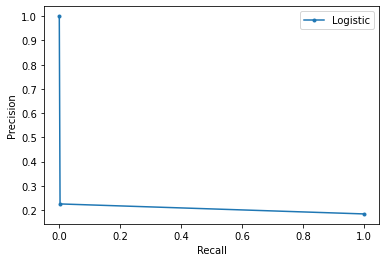

In [195]:
models = [
    LogisticRegression()
]

for clf in models:
    model_name = clf.__class__.__name__
    clf.fit(x_train, y_train)
    print(model_name)
    # Do the prediction
    y_predict=clf.predict(x_test)
    print(confusion_matrix(y_test,y_predict))
    recall=recall_score(y_test,y_predict,average='macro')
    precision=precision_score(y_test,y_predict,average='macro')
    f1score=f1_score(y_test,y_predict,average='macro')
    accuracy=accuracy_score(y_test,y_predict)
    matthews = matthews_corrcoef(y_test,y_predict) 
    print('Accuracy: '+ str(accuracy))
    print('Macro Precision: '+ str(precision))
    print('Macro Recall: '+ str(recall))
    print('Macro F1 score:'+ str(f1score))
lr_precision, lr_recall, _ = precision_recall_curve(y_test,y_predict)
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## Using Bert Tokenizer and statistical model on 1000 CompVis records 

In [196]:
y_train = np.asarray(CompVisLabels)
y_test = np.asarray(CompVis_testLabels)

LogisticRegression
[[17482    44]
 [ 2148     4]]
Accuracy: 0.8886065657078971
Macro Precision: 0.4869544914246901
Macro Recall: 0.49967409015686515
Macro F1 score:0.4723209270006557


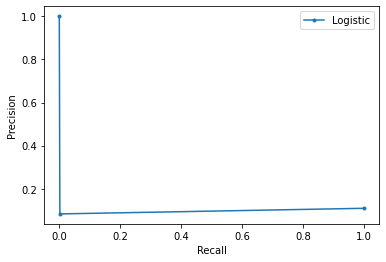

In [197]:
models = [
    LogisticRegression()
]

for clf in models:
    model_name = clf.__class__.__name__
    clf.fit(x_train, y_train)
    print(model_name)
    # Do the prediction
    y_predict=clf.predict(x_test)
    print(confusion_matrix(y_test,y_predict))
    recall=recall_score(y_test,y_predict,average='macro')
    precision=precision_score(y_test,y_predict,average='macro')
    f1score=f1_score(y_test,y_predict,average='macro')
    accuracy=accuracy_score(y_test,y_predict)
    matthews = matthews_corrcoef(y_test,y_predict) 
    print('Accuracy: '+ str(accuracy))
    print('Macro Precision: '+ str(precision))
    print('Macro Recall: '+ str(recall))
    print('Macro F1 score:'+ str(f1score))
lr_precision, lr_recall, _ = precision_recall_curve(y_test,y_predict)
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## Using Bert Tokenizer and statistical model on 1000 Math records..

In [198]:
y_train = np.asarray(MathLabels)
y_test = np.asarray(Math_testLabels)

LogisticRegression
[[13748     0]
 [ 5930     0]]
Accuracy: 0.6986482366094116
Macro Precision: 0.3493241183047058
Macro Recall: 0.5
Macro F1 score:0.4112965954646084


/Users/chaitanyamuvva/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chaitanyamuvva/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


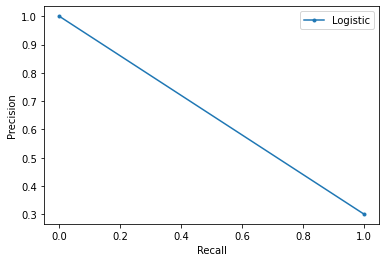

In [199]:
models = [
    LogisticRegression()
]

for clf in models:
    model_name = clf.__class__.__name__
    clf.fit(x_train, y_train)
    print(model_name)
    # Do the prediction
    y_predict=clf.predict(x_test)
    print(confusion_matrix(y_test,y_predict))
    recall=recall_score(y_test,y_predict,average='macro')
    precision=precision_score(y_test,y_predict,average='macro')
    f1score=f1_score(y_test,y_predict,average='macro')
    accuracy=accuracy_score(y_test,y_predict)
    matthews = matthews_corrcoef(y_test,y_predict) 
    print('Accuracy: '+ str(accuracy))
    print('Macro Precision: '+ str(precision))
    print('Macro Recall: '+ str(recall))
    print('Macro F1 score:'+ str(f1score))
lr_precision, lr_recall, _ = precision_recall_curve(y_test,y_predict)
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

# 2: Topic Modelling

In [2]:
%matplotlib inline

In [5]:
import io
import os.path
import re
import tarfile
import smart_open
import pandas as pd

In [6]:
train_path=".//assignment1_data/axcs_train.csv"
test_path=".//assignment1_data/axcs_test.csv"

In [26]:
text_data = []
df_train = pd.read_csv(train_path)
df_train_1000 = df_train[:1000]
df_train_20000 = df_train[:20000]

/Users/chaitanyamuvva/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
len(df_train)

54731

In [10]:
len(df_train_1000)

1000

## LDA with K=10 and 20K training records

In [27]:
docs = df_train_20000['Abstract'].tolist()

/Users/chaitanyamuvva/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
from nltk.tokenize import RegexpTokenizer

# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(docs)):
    docs[idx] = docs[idx].lower()  # Convert to lowercase.
    docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

docs = [[token for token in doc if len(token) > 1] for doc in docs]

/Users/chaitanyamuvva/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/chaitanyamuvva/opt/anaconda3/lib/python3.8/asyncio/events.py:81: DeprecationWarning: `run_cell_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  self._context.run(self._callback, *self._args)


In [29]:
# Lemmatize the documents.
from nltk.stem.wordnet import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

/Users/chaitanyamuvva/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/chaitanyamuvva/opt/anaconda3/lib/python3.8/asyncio/events.py:81: DeprecationWarning: `run_cell_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  self._context.run(self._callback, *self._args)


In [30]:
#!pip3 install gensim
from gensim.models import Phrases

#only ones that appear 20 times or more.
bigram = Phrases(docs, min_count=25)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

/Users/chaitanyamuvva/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
# Remove rare and common tokens.
from gensim.corpora import Dictionary

dictionary = Dictionary(docs)

dictionary.filter_extremes(no_below=20, no_above=0.5)

/Users/chaitanyamuvva/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
corpus = [dictionary.doc2bow(doc) for doc in docs]

/Users/chaitanyamuvva/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/chaitanyamuvva/opt/anaconda3/lib/python3.8/asyncio/events.py:81: DeprecationWarning: `run_cell_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  self._context.run(self._callback, *self._args)


In [33]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 6303
Number of documents: 20000


/Users/chaitanyamuvva/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
# Train LDA model.
from gensim.models import LdaModel

#training parameters.
NUM_TOPICS = 10
chunksize = 2000
passes = 20
iterations = 400
eval_every = None 

temp = dictionary[0]  
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=NUM_TOPICS,
    passes=passes,
    eval_every=eval_every
)
outputfile = f'model{NUM_TOPICS}.gensim'
print("Saving model in " + outputfile)
print("")
model.save(outputfile)

/Users/chaitanyamuvva/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Saving model in model10.gensim



In [35]:
top_topics = model.top_topics(corpus)
model.num_topics

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / NUM_TOPICS
print('Average topic coherence: %.4f.' % avg_topic_coherence)

model.print_topics( num_words=20)

/Users/chaitanyamuvva/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/chaitanyamuvva/opt/anaconda3/lib/python3.8/asyncio/events.py:81: DeprecationWarning: `run_cell_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  self._context.run(self._callback, *self._args)


Average topic coherence: -2.1161.


[(0,
  '0.015*"problem" + 0.015*"be" + 0.012*"it" + 0.010*"set" + 0.010*"can" + 0.010*"a" + 0.009*"which" + 0.008*"function" + 0.008*"one" + 0.007*"show" + 0.007*"can_be" + 0.007*"two" + 0.007*"result" + 0.007*"number" + 0.006*"graph" + 0.006*"such" + 0.006*"quantum" + 0.006*"complexity" + 0.006*"class" + 0.006*"all"'),
 (1,
  '0.092*"network" + 0.025*"node" + 0.016*"wireless" + 0.014*"power" + 0.010*"transmission" + 0.010*"link" + 0.009*"mobile" + 0.009*"energy" + 0.008*"delay" + 0.008*"system" + 0.008*"a" + 0.008*"distributed" + 0.008*"performance" + 0.008*"communication" + 0.007*"routing" + 0.007*"throughput" + 0.006*"at" + 0.006*"control" + 0.006*"traffic" + 0.006*"user"'),
 (2,
  '0.052*"channel" + 0.039*"code" + 0.022*"rate" + 0.016*"capacity" + 0.015*"coding" + 0.012*"interference" + 0.012*"error" + 0.012*"source" + 0.011*"decoding" + 0.010*"information" + 0.010*"scheme" + 0.009*"at" + 0.009*"multiple" + 0.009*"receiver" + 0.008*"feedback" + 0.007*"mimo" + 0.007*"bit" + 0.007*"r

In [36]:
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

/Users/chaitanyamuvva/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## LDA with K=10 and first 1000 training records

In [22]:
docs = df_train_1000['Abstract'].tolist()

from nltk.tokenize import RegexpTokenizer

# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(docs)):
    docs[idx] = docs[idx].lower()  # Convert to lowercase.
    docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

docs = [[token for token in doc if len(token) > 1] for doc in docs]

# Lemmatize the documents.
from nltk.stem.wordnet import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

#!pip3 install gensim
from gensim.models import Phrases

#only ones that appear 20 times or more.
bigram = Phrases(docs, min_count=25)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

# Remove rare and common tokens.
from gensim.corpora import Dictionary

dictionary = Dictionary(docs)

dictionary.filter_extremes(no_below=20, no_above=0.5)

corpus = [dictionary.doc2bow(doc) for doc in docs]

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

# Train LDA model.
from gensim.models import LdaModel

#training parameters.
NUM_TOPICS = 10
chunksize = 2000
passes = 20
iterations = 400
eval_every = None 

temp = dictionary[0]  
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=NUM_TOPICS,
    passes=passes,
    eval_every=eval_every
)
outputfile = f'model{NUM_TOPICS}.gensim'
print("Saving model in " + outputfile)
print("")
model.save(outputfile)

top_topics = model.top_topics(corpus)
model.num_topics

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / NUM_TOPICS
print('Average topic coherence: %.4f.' % avg_topic_coherence)

model.print_topics( num_words=20)

import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

/Users/chaitanyamuvva/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/chaitanyamuvva/opt/anaconda3/lib/python3.8/asyncio/events.py:81: DeprecationWarning: `run_cell_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  self._context.run(self._callback, *self._args)


Number of unique tokens: 715
Number of documents: 1000
Saving model in model10.gensim

Average topic coherence: -1.6016.


## LDA with K=40 and 20K training records

In [37]:
docs = df_train_20000['Abstract'].tolist()

from nltk.tokenize import RegexpTokenizer

# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(docs)):
    docs[idx] = docs[idx].lower()  # Convert to lowercase.
    docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

docs = [[token for token in doc if len(token) > 1] for doc in docs]

# Lemmatize the documents.
from nltk.stem.wordnet import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

#!pip3 install gensim
from gensim.models import Phrases

#only ones that appear 20 times or more.
bigram = Phrases(docs, min_count=25)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

# Remove rare and common tokens.
from gensim.corpora import Dictionary

dictionary = Dictionary(docs)

dictionary.filter_extremes(no_below=20, no_above=0.5)

corpus = [dictionary.doc2bow(doc) for doc in docs]

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

# Train LDA model.
from gensim.models import LdaModel

#training parameters.
NUM_TOPICS = 40
chunksize = 2000
passes = 20
iterations = 400
eval_every = None 

temp = dictionary[0]  
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=NUM_TOPICS,
    passes=passes,
    eval_every=eval_every
)
outputfile = f'model{NUM_TOPICS}.gensim'
print("Saving model in " + outputfile)
print("")
model.save(outputfile)

top_topics = model.top_topics(corpus)
model.num_topics

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / NUM_TOPICS
print('Average topic coherence: %.4f.' % avg_topic_coherence)

model.print_topics( num_words=20)

import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

/Users/chaitanyamuvva/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/chaitanyamuvva/opt/anaconda3/lib/python3.8/asyncio/events.py:81: DeprecationWarning: `run_cell_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  self._context.run(self._callback, *self._args)


Number of unique tokens: 6303
Number of documents: 20000
Saving model in model40.gensim

Average topic coherence: -3.9125.


## LDA with K=40 and first 1000 training records

In [25]:
docs = df_train_1000['Abstract'].tolist()

from nltk.tokenize import RegexpTokenizer

# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(docs)):
    docs[idx] = docs[idx].lower()  # Convert to lowercase.
    docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

docs = [[token for token in doc if len(token) > 1] for doc in docs]

# Lemmatize the documents.
from nltk.stem.wordnet import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

#!pip3 install gensim
from gensim.models import Phrases

#only ones that appear 20 times or more.
bigram = Phrases(docs, min_count=25)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

# Remove rare and common tokens.
from gensim.corpora import Dictionary

dictionary = Dictionary(docs)

dictionary.filter_extremes(no_below=20, no_above=0.5)

corpus = [dictionary.doc2bow(doc) for doc in docs]

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

# Train LDA model.
from gensim.models import LdaModel

#training parameters.
NUM_TOPICS = 40
chunksize = 2000
passes = 20
iterations = 400
eval_every = None 

temp = dictionary[0]  
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=NUM_TOPICS,
    passes=passes,
    eval_every=eval_every
)
outputfile = f'model{NUM_TOPICS}.gensim'
print("Saving model in " + outputfile)
print("")
model.save(outputfile)

top_topics = model.top_topics(corpus)
model.num_topics

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / NUM_TOPICS
print('Average topic coherence: %.4f.' % avg_topic_coherence)

model.print_topics( num_words=20)

import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

/Users/chaitanyamuvva/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/chaitanyamuvva/opt/anaconda3/lib/python3.8/asyncio/events.py:81: DeprecationWarning: `run_cell_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  self._context.run(self._callback, *self._args)


Number of unique tokens: 715
Number of documents: 1000
Saving model in model40.gensim

Average topic coherence: -1.9661.
